In [1]:
# This is used to increase the notebook's width to fill the screen, allowing for better plot visualization
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from utils import plot
from utils import split

C:\Users\leoar\AppData\Local\Temp\ipykernel_11132\269297166.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Path to Dataset

In [2]:
# Path to dataset
metadata_dir = os.path.join( "..", "metadata" )
assert os.path.exists( metadata_dir ), f"Can't find {metadata_dir}, please check 'metadata_dir'..."

## Samples Dataframe

In [3]:
# Path to metadata csv
csv_path = os.path.join( metadata_dir, "new_split_metadata.csv" )

# Reads metadata as dataframe, "age" column is treated as str since "N/A" can't be int
samples_df = pd.read_csv(csv_path, sep = ";", na_filter = False, dtype={"age": str})

samples_df.head()

filename patient_id source     class country sex   age  \
0  NCP_96_1328_0032.png     NCP_96   CNCB  COVID-19   China   M  74.0   
1  NCP_96_1328_0035.png     NCP_96   CNCB  COVID-19   China   M  74.0   
2  NCP_96_1328_0036.png     NCP_96   CNCB  COVID-19   China   M  74.0   
3  NCP_96_1328_0037.png     NCP_96   CNCB  COVID-19   China   M  74.0   
4  NCP_96_1328_0038.png     NCP_96   CNCB  COVID-19   China   M  74.0   

  partition slice_selection  x_min  y_min  x_max  y_max verified_finding  \
0     train          Expert      9     94    512    405              Yes   
1     train          Expert     10    106    512    405              Yes   
2     train          Expert     10    105    512    406              Yes   
3     train          Expert     11    104    512    406              Yes   
4     train          Expert     11    103    512    406              Yes   

    view modality  
0  Axial       CT  
1  Axial       CT  
2  Axial       CT  
3  Axial       CT  
4  Axial       CT

## Patients Dataframe

In [4]:
# Creates a new dataframe with metadata sorted by patient
patient_df = plot.convert_df_sample2patient( samples_df )

patient_df.head()

patient_id source     class country  sex   age partition slice_selection  \
0     NCP_96   CNCB  COVID-19   China    M  74.0     train          Expert   
1    NCP_270   CNCB  COVID-19   China  N/A   N/A       val          Expert   
2    NCP_322   CNCB  COVID-19   China  N/A   N/A     train          Expert   
3   NCP_1276   CNCB  COVID-19   China  N/A   N/A      test          Expert   
4   NCP_2683   CNCB  COVID-19   China  N/A   N/A      test          Expert   

  verified_finding   view modality  sample_count  
0              Yes  Axial       CT           121  
1              Yes  Axial       CT           124  
2              Yes  Axial       CT            40  
3              Yes  Axial       CT            32  
4              Yes  Axial       CT             9

# Split Function

In [5]:
def gen_comb_partition_groups( age_bin_len = None ):
    
    # Age bins
    if age_bin_len is None:
        age_bins = list(np.arange(0, 101, 5))
    else:
        age_bins = list(np.arange(0, 101, age_bin_len))
        
    
    # Possible values for all varying metadata
    possible_values_dict = { "age":             [ "N/A" ] + [ (age_bins[i], age_bins[i+1]) for i in range(len(age_bins)-1) ],
                             "sex":             [ "N/A", "M", "F" ],
                             "class":           [ "Normal", "Pneumonia", "COVID-19" ],
                             "partition":       [ "train", "val", "test" ],
                             "slice_selection": [ "N/A", "Expert", "Automatic", "Non-expert" ],
                             "country":         [ "N/A", "China", "Iran", "Australia", "Italy", 
                                                  "Algeria", "Belgium", "England", "Scotland", 
                                                  "Turkey", "Azerbaijan", "Lebanon", "Ukraine", 
                                                  "Afghanistan", "Peru" ]
                           }
    
    # Makes a list with all lists of possible values to compute all possible combinations
    lists_of_possible_values = [ possible_values_dict[key] for key in possible_values_dict.keys() ]
    
    # Uses itertools to compute all possible value combinations and stores it to a list of tuples
    group_list = list( itertools.product( *lists_of_possible_values ) )
    
    # Generates a dictionary from the list of tuples in order to build a dataframe
    group_dict = { key: [g[idx] for g in group_list] for idx, key in enumerate(possible_values_dict.keys()) }
    
    # Splits (start_age, final_age) tuples to make two different columns
    group_dict["start_age"] = [g[0][0] if isinstance(g[0], tuple) else "N/A" for g in group_list ]
    group_dict["final_age"] = [g[0][1] if isinstance(g[0], tuple) else "N/A" for g in group_list ]
    
    # Creates the dataframe
    group_df = pd.DataFrame.from_dict(group_dict)
    
    return group_df

def combine_CNCB_iCTCF( s_df, p_df, age_bin_len = 20, seed = 25 ):
    
    # Separates the COVID-19 samples from CNCB to make the base dataframe of the miniCNCB
    comb_s_df_a = s_df[ (s_df["source"] == "CNCB") & (s_df["class"] == "COVID-19") ].copy( deep = True )
    comb_p_df_a = p_df[ (p_df["source"] == "CNCB") & (p_df["class"] == "COVID-19") ].copy( deep = True )
    
    # Changes source to miniCNCB and resets index
    comb_s_df_a["source"] = "miniCNCB"
    comb_p_df_a["source"] = "miniCNCB"
    comb_s_df_a.reset_index(drop = True, inplace = True)
    comb_p_df_a.reset_index(drop = True, inplace = True)
    print(f"miniCNCB: {len(comb_s_df_a)} samples & {len(comb_p_df_a)} patients")
    
    # Separates the COVID-19 samples from iCTCF to make the base dataframe of the Comp_CNCB_iCTCF
    comb_s_df_b = s_df[ (s_df["source"] == "iCTCF") & (s_df["class"] == "COVID-19") ].copy( deep = True )
    comb_p_df_b = p_df[ (p_df["source"] == "iCTCF") & (p_df["class"] == "COVID-19") ].copy( deep = True )
    
    # Changes source to Comp_CNCB_iCTCF and resets index
    comb_s_df_b["source"] = "Comp_CNCB_iCTCF"
    comb_p_df_b["source"] = "Comp_CNCB_iCTCF"
    comb_s_df_b.reset_index(drop = True, inplace = True)
    comb_p_df_b.reset_index(drop = True, inplace = True)
    print(f"comb_df: {len(comb_s_df_b)} samples & {len(comb_p_df_b)} patients")
    
    # Separates the non COVID-19 samples from CNCB to split them amongst miniCNCB and Comp_CNCB_iCTCF
    to_split_s_df = s_df[ (s_df["source"] == "CNCB") & (s_df["class"] != "COVID-19") ].copy( deep = True )
    to_split_p_df = p_df[ (p_df["source"] == "CNCB") & (p_df["class"] != "COVID-19") ].copy( deep = True )
    to_split_s_df.reset_index(drop = True, inplace = True)
    to_split_p_df.reset_index(drop = True, inplace = True)
    print(f"to_split_df: {len(to_split_s_df)} samples & {len(to_split_p_df)} patients")
    
    # Generates a dataframe with all possible value combinations for all varying metadata & current partitions 
    # and associates a number to each combination
    group_df = gen_comb_partition_groups( age_bin_len = age_bin_len )
    
    # Creates a new column to assign a group to each patient in the dataset
    # This group refers to the specific combination of values for the metadata considered by group_df
    metadata_cols = [ "sex", "class", "partition", "slice_selection", "country", "age" ]
    to_split_p_df["group"] = to_split_p_df.apply( lambda x: split.assign_group( x, group_df, col_list = metadata_cols ), axis = 1 )
    
    # Replicates the group column to the sample dataframe
    id2group_dict = { row["patient_id"]: row["group"] for idx, row in to_split_p_df.iterrows() }
    to_split_s_df["group"] = to_split_s_df.apply( lambda x: id2group_dict[x["patient_id"]], axis = 1 )
    
    # Shuffles to_split_p_df according to the provided seed
    to_split_p_df = to_split_p_df.sample(frac=1, random_state = seed).reset_index(drop=True)
    
    # Computes the unique groups and their respective number of patients
    unq_groups = np.unique( to_split_p_df["group"].to_list() )
    
    selected_pt_b_patient_ids = []
    for g_idx, group in enumerate(unq_groups):
        group_as_tuple = tuple([ group_df.iloc[group, :][col] for col in [ "sex", "class", "partition", "slice_selection", "country", "age" ] ])
        print("{}/{}: Group {}".format( str(g_idx+1).rjust(5), len(unq_groups), group_as_tuple ))
    
        # Copies sub_sample_df and sub_patient_df while filtering their rows to keep only rows regarding the current group
        group_s_df  = to_split_s_df[ to_split_s_df["group"] == group ].copy( deep = True )
        group_p_df  = to_split_p_df[ to_split_p_df["group"] == group ].copy( deep = True )

        # Resets the index for both dataframes
        group_s_df.reset_index(drop = True, inplace = True)
        group_p_df.reset_index(drop = True, inplace = True)
        
        # Computes the number of samples from the current group to move to split
        n_pt_b_samples = int(0.5 * len(group_s_df))
        
        selected_patients, n_selected_samples = split.select_patients( group_p_df, n_pt_b_samples )
        print("\t[Test] Moved {} samples ({} patients), expected {} samples, had {} samples ({} patients)...".format( n_selected_samples,
                                                                                                              len(selected_patients),
                                                                                                              n_pt_b_samples,
                                                                                                              len(group_s_df),
                                                                                                              len(group_p_df) ))
        print("\t\tList of sample counts:", group_p_df["sample_count"].to_list() )
        
        # Adds selected patients to the selected val list
        selected_pt_b_patient_ids = selected_pt_b_patient_ids + selected_patients
        
        print("\n\n")
    
    # Drops group columns as its no longe necessary
    to_split_s_df.drop(["group"], inplace = True, axis=1)
    to_split_p_df.drop(["group"], inplace = True, axis=1)
    
    # Changes the source of the rows based on the selected ids from selected_pt_b_patient_ids, selected IDs go to pt_b and the others to pt_a
    to_split_s_df["source"] = to_split_s_df.apply(lambda x: "Comp_CNCB_iCTCF" if (x["patient_id"] in selected_pt_b_patient_ids) else "miniCNCB", axis = 1 )
    to_split_p_df["source"] = to_split_p_df.apply(lambda x: "Comp_CNCB_iCTCF" if (x["patient_id"] in selected_pt_b_patient_ids) else "miniCNCB", axis = 1 )
    
    dst_sample_df  = pd.concat([to_split_s_df, comb_s_df_a, comb_s_df_b], ignore_index=True)
    dst_patient_df = pd.concat([to_split_p_df, comb_p_df_a, comb_p_df_b], ignore_index=True)
    print(f"dst_df: {len(dst_sample_df)} samples & {len(dst_patient_df)} patients")
    
    return dst_sample_df, dst_patient_df

# Combining CNCB + iCTCF 

These two datasets are combined so that 1 trainable dataset + 1 non-trainable dataset makes 2 trainables datasets: Comb_CNCB_iCTCF_a and Comb_CNCB_iCTCF_b

In [6]:
samples_df, patient_df = combine_CNCB_iCTCF( samples_df, patient_df, age_bin_len = 20, seed = 25 )

miniCNCB: 31070 samples & 776 patients
comb_df: 45912 samples & 709 patients
to_split_df: 84767 samples & 1078 patients
    1/10: Group ('N/A', 'Normal', 'train', 'N/A', 'China', 'N/A')
	[Test] Moved 13741 samples (72 patients), expected 13742 samples, had 27485 samples (140 patients)...
		List of sample counts: [154, 124, 36, 192, 117, 72, 100, 632, 148, 66, 256, 134, 27, 775, 120, 107, 325, 148, 130, 284, 128, 128, 104, 89, 75, 231, 205, 321, 258, 188, 138, 220, 63, 179, 292, 390, 201, 31, 398, 152, 336, 120, 211, 258, 287, 346, 22, 138, 201, 116, 411, 682, 107, 114, 234, 142, 83, 29, 289, 30, 77, 261, 142, 287, 140, 56, 370, 806, 130, 126, 142, 22, 823, 122, 418, 94, 278, 129, 320, 22, 148, 206, 66, 112, 340, 182, 290, 340, 188, 180, 30, 28, 122, 132, 210, 152, 118, 25, 614, 138, 286, 343, 136, 288, 28, 308, 219, 134, 428, 353, 142, 24, 136, 73, 436, 260, 300, 140, 116, 182, 70, 118, 76, 55, 327, 142, 25, 110, 281, 209, 306, 133, 103, 208, 216, 63, 120, 73, 118, 120]



    2/10: Gr

# Plots of Comp_CNCB_iCTCF_a

In [7]:
dataset_name = "miniCNCB"

## Class

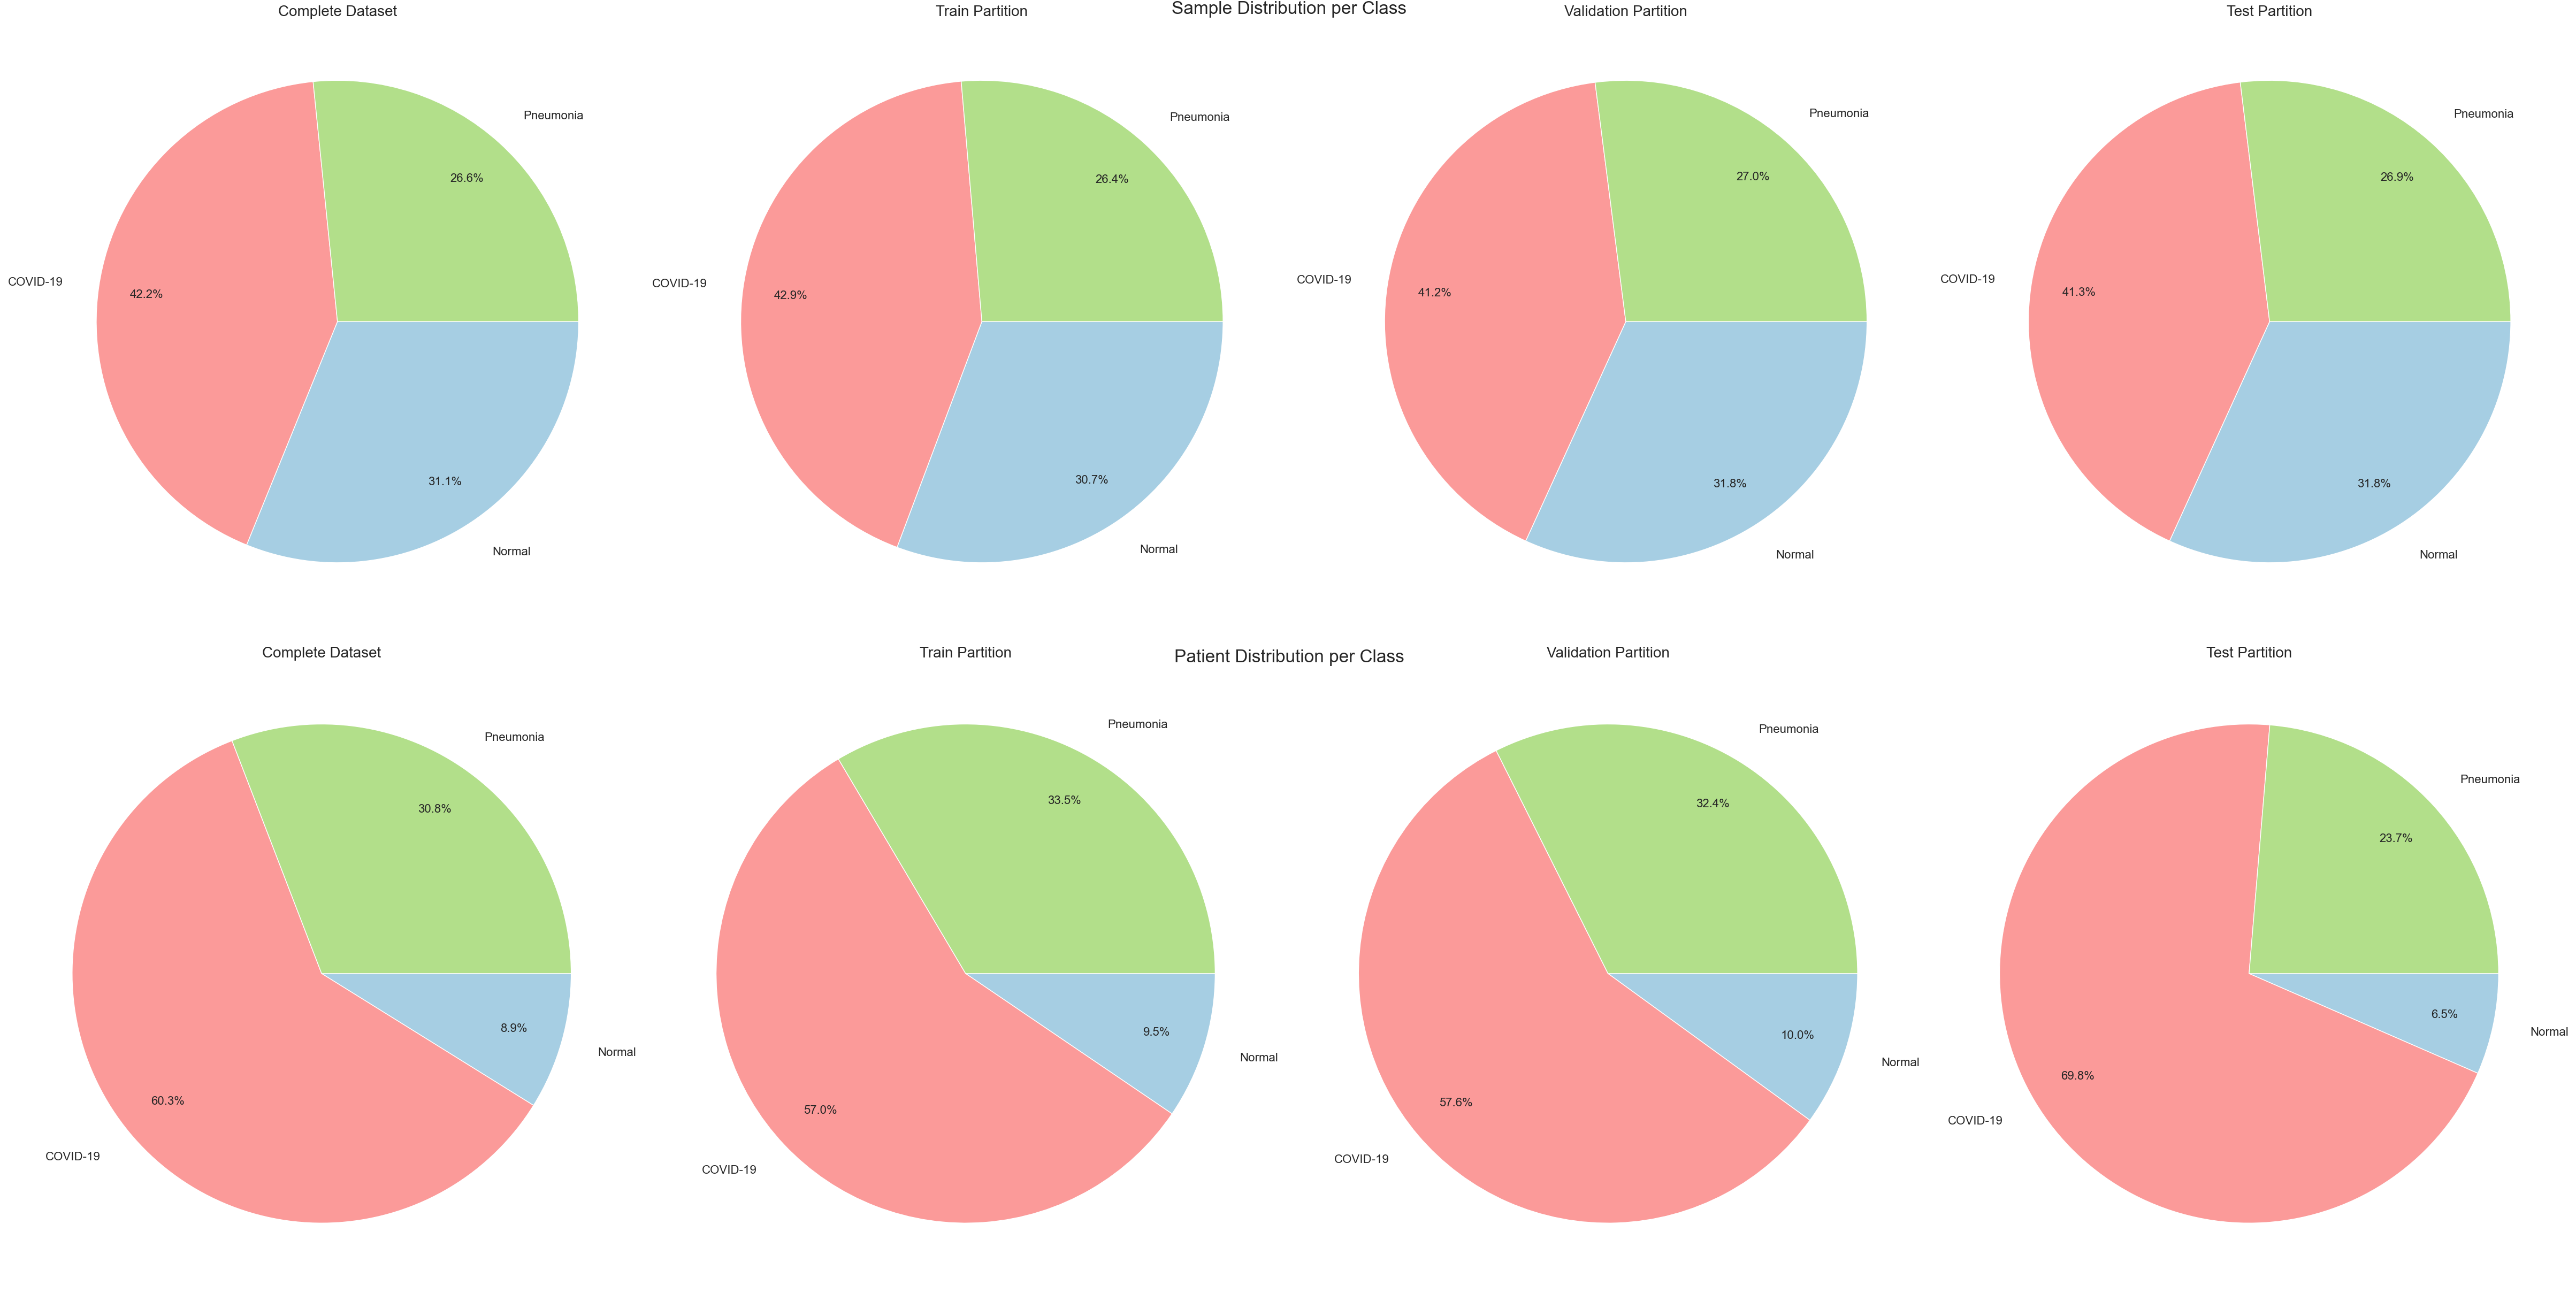

In [8]:
plot.column_as_pies( samples_df, patient_df, "class", dataset_name, figsize = (48, 24) )

In [9]:
plot.column_as_table( samples_df, patient_df, "class", dataset_name, bin_flag = False )

Sample Distribution
 by Class 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 COVID-19 
 31070 
 19198 
 5919 
 5953 
 
 
 Normal 
 22909 
 13744 
 4575 
 4590 
 
 
 Pneumonia 
 19572 
 11796 
 3888 
 3888 
 
 
 SUM 
 73551 
 44738 
 14382 
 14431 
 
 
 Patient Distribution
 by Class 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 COVID-19 
 776 
 408 
 144 
 224 
 
 
 Pneumonia 
 397 
 240 
 81 
 76 
 
 
 Normal 
 114 
 68 
 25 
 21 
 
 
 SUM 
 1287 
 716 
 250 
 321

## Age

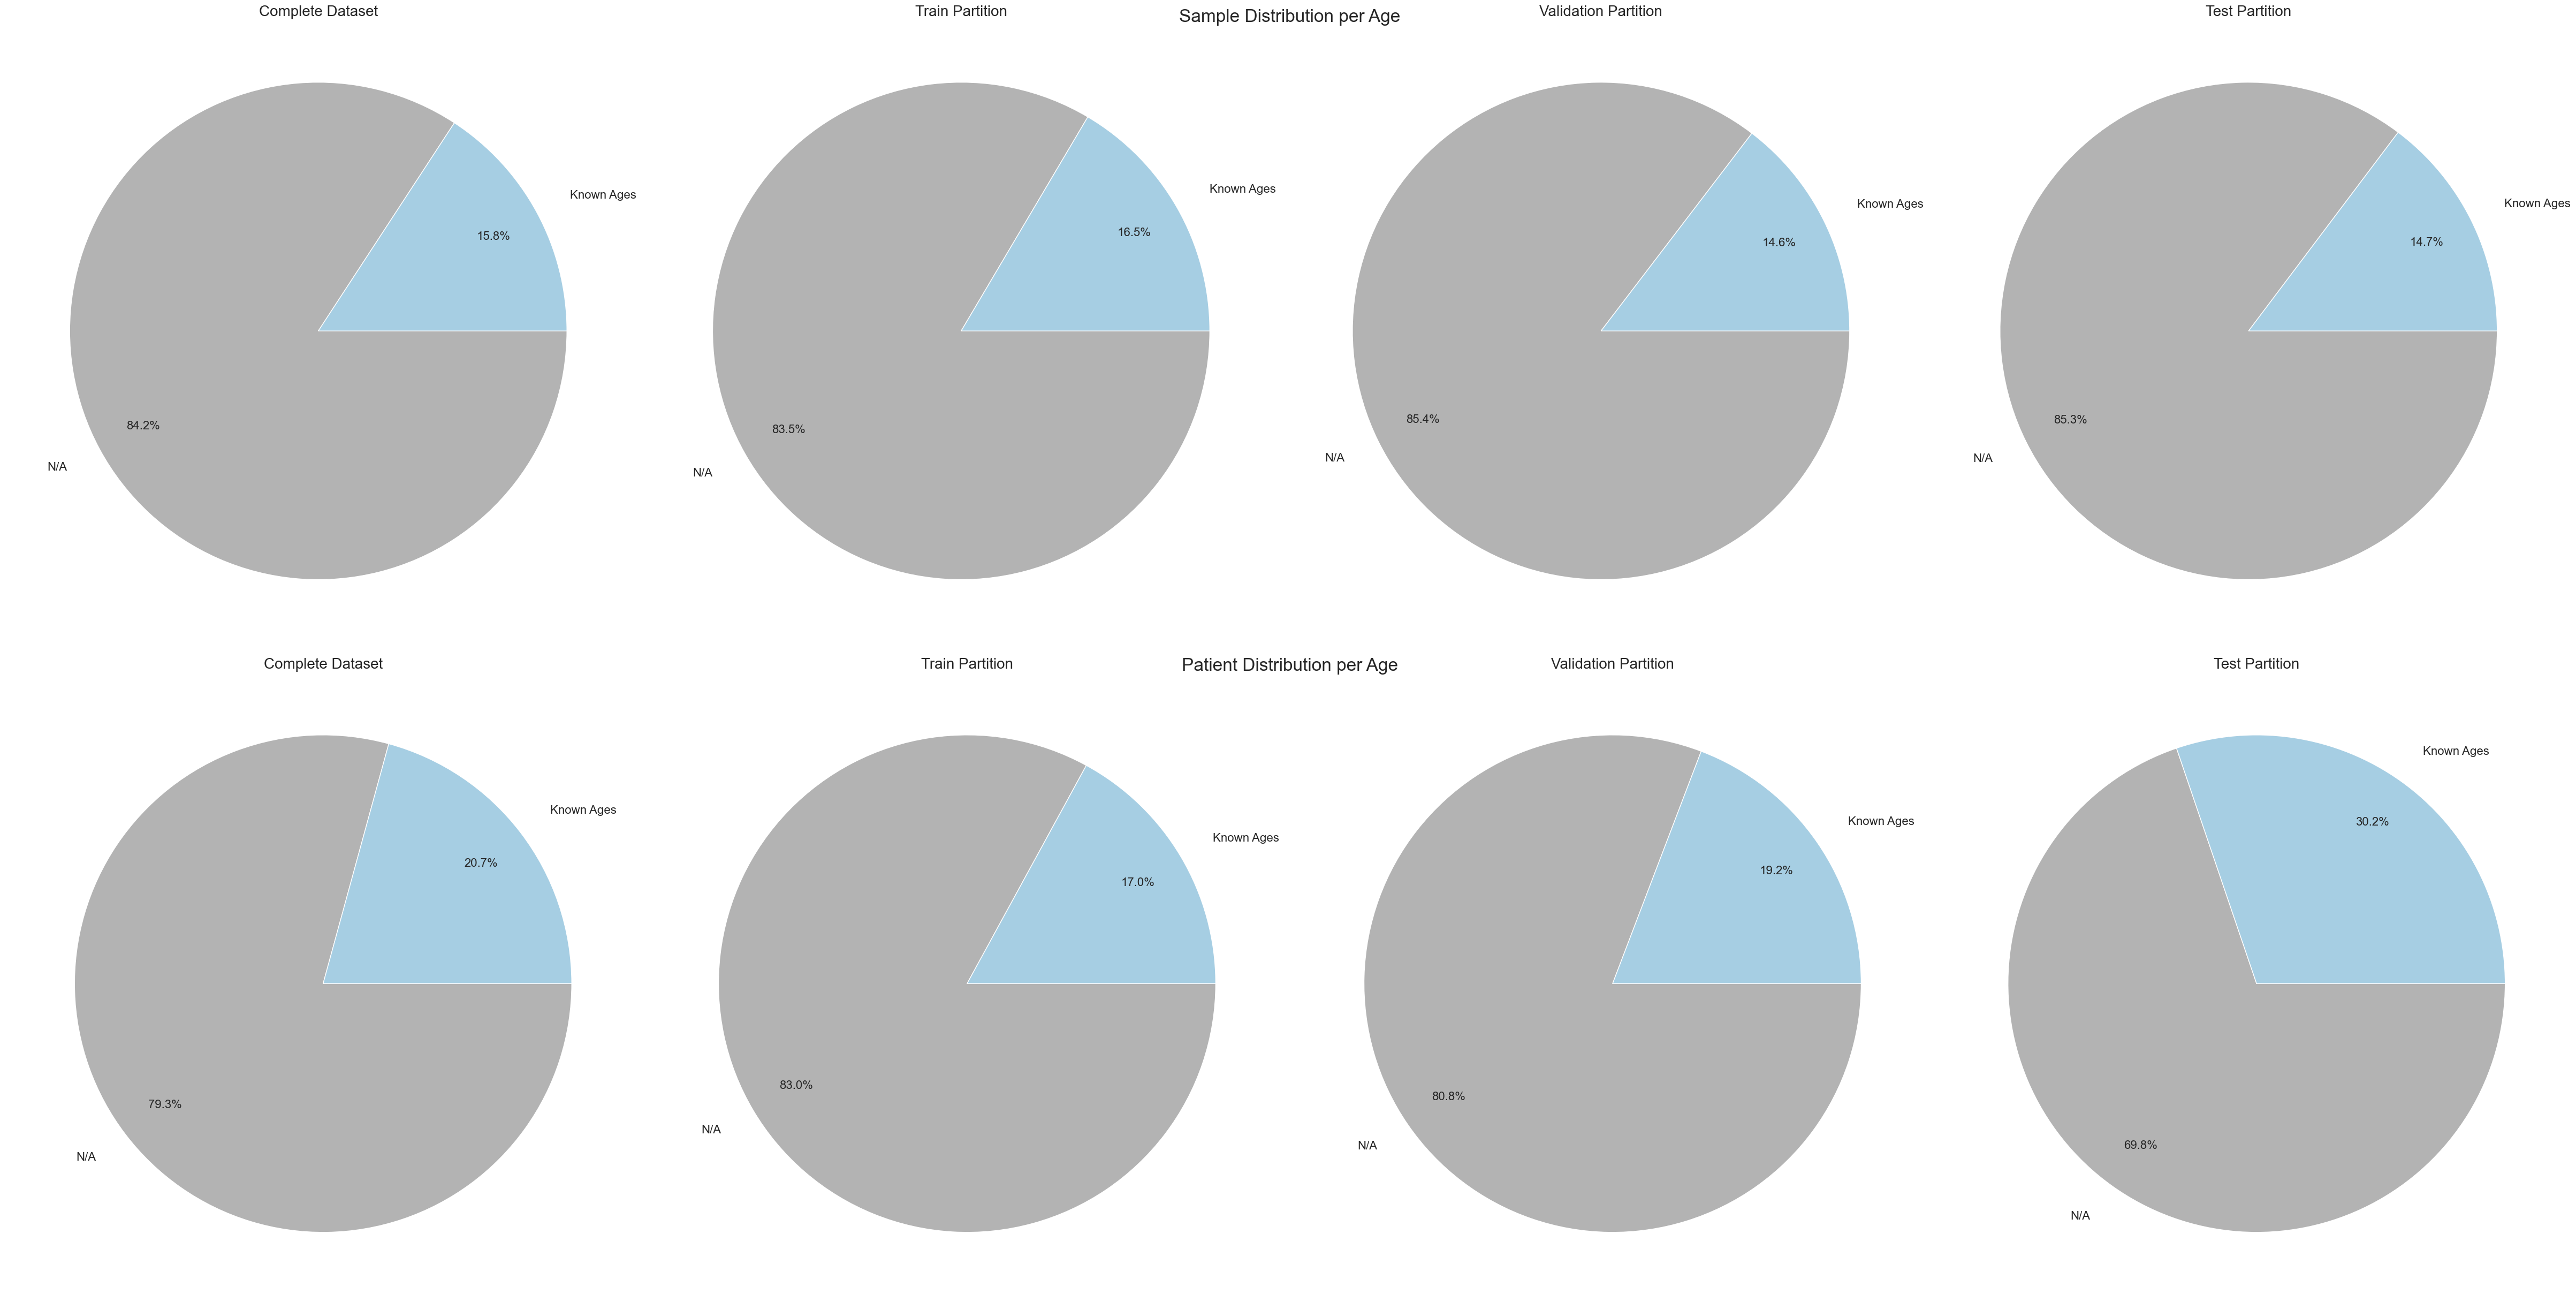

In [10]:
plot.column_as_pies( samples_df, patient_df, "age", dataset_name, figsize = (48, 24))

In [11]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = False )

Sample Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 61944 
 37359 
 12279 
 12306 
 
 
 Known Ages 
 11607 
 7379 
 2103 
 2125 
 
 
 SUM 
 73551 
 44738 
 14382 
 14431 
 
 
 Patient Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 1020 
 594 
 202 
 224 
 
 
 Known Ages 
 267 
 122 
 48 
 97 
 
 
 SUM 
 1287 
 716 
 250 
 321

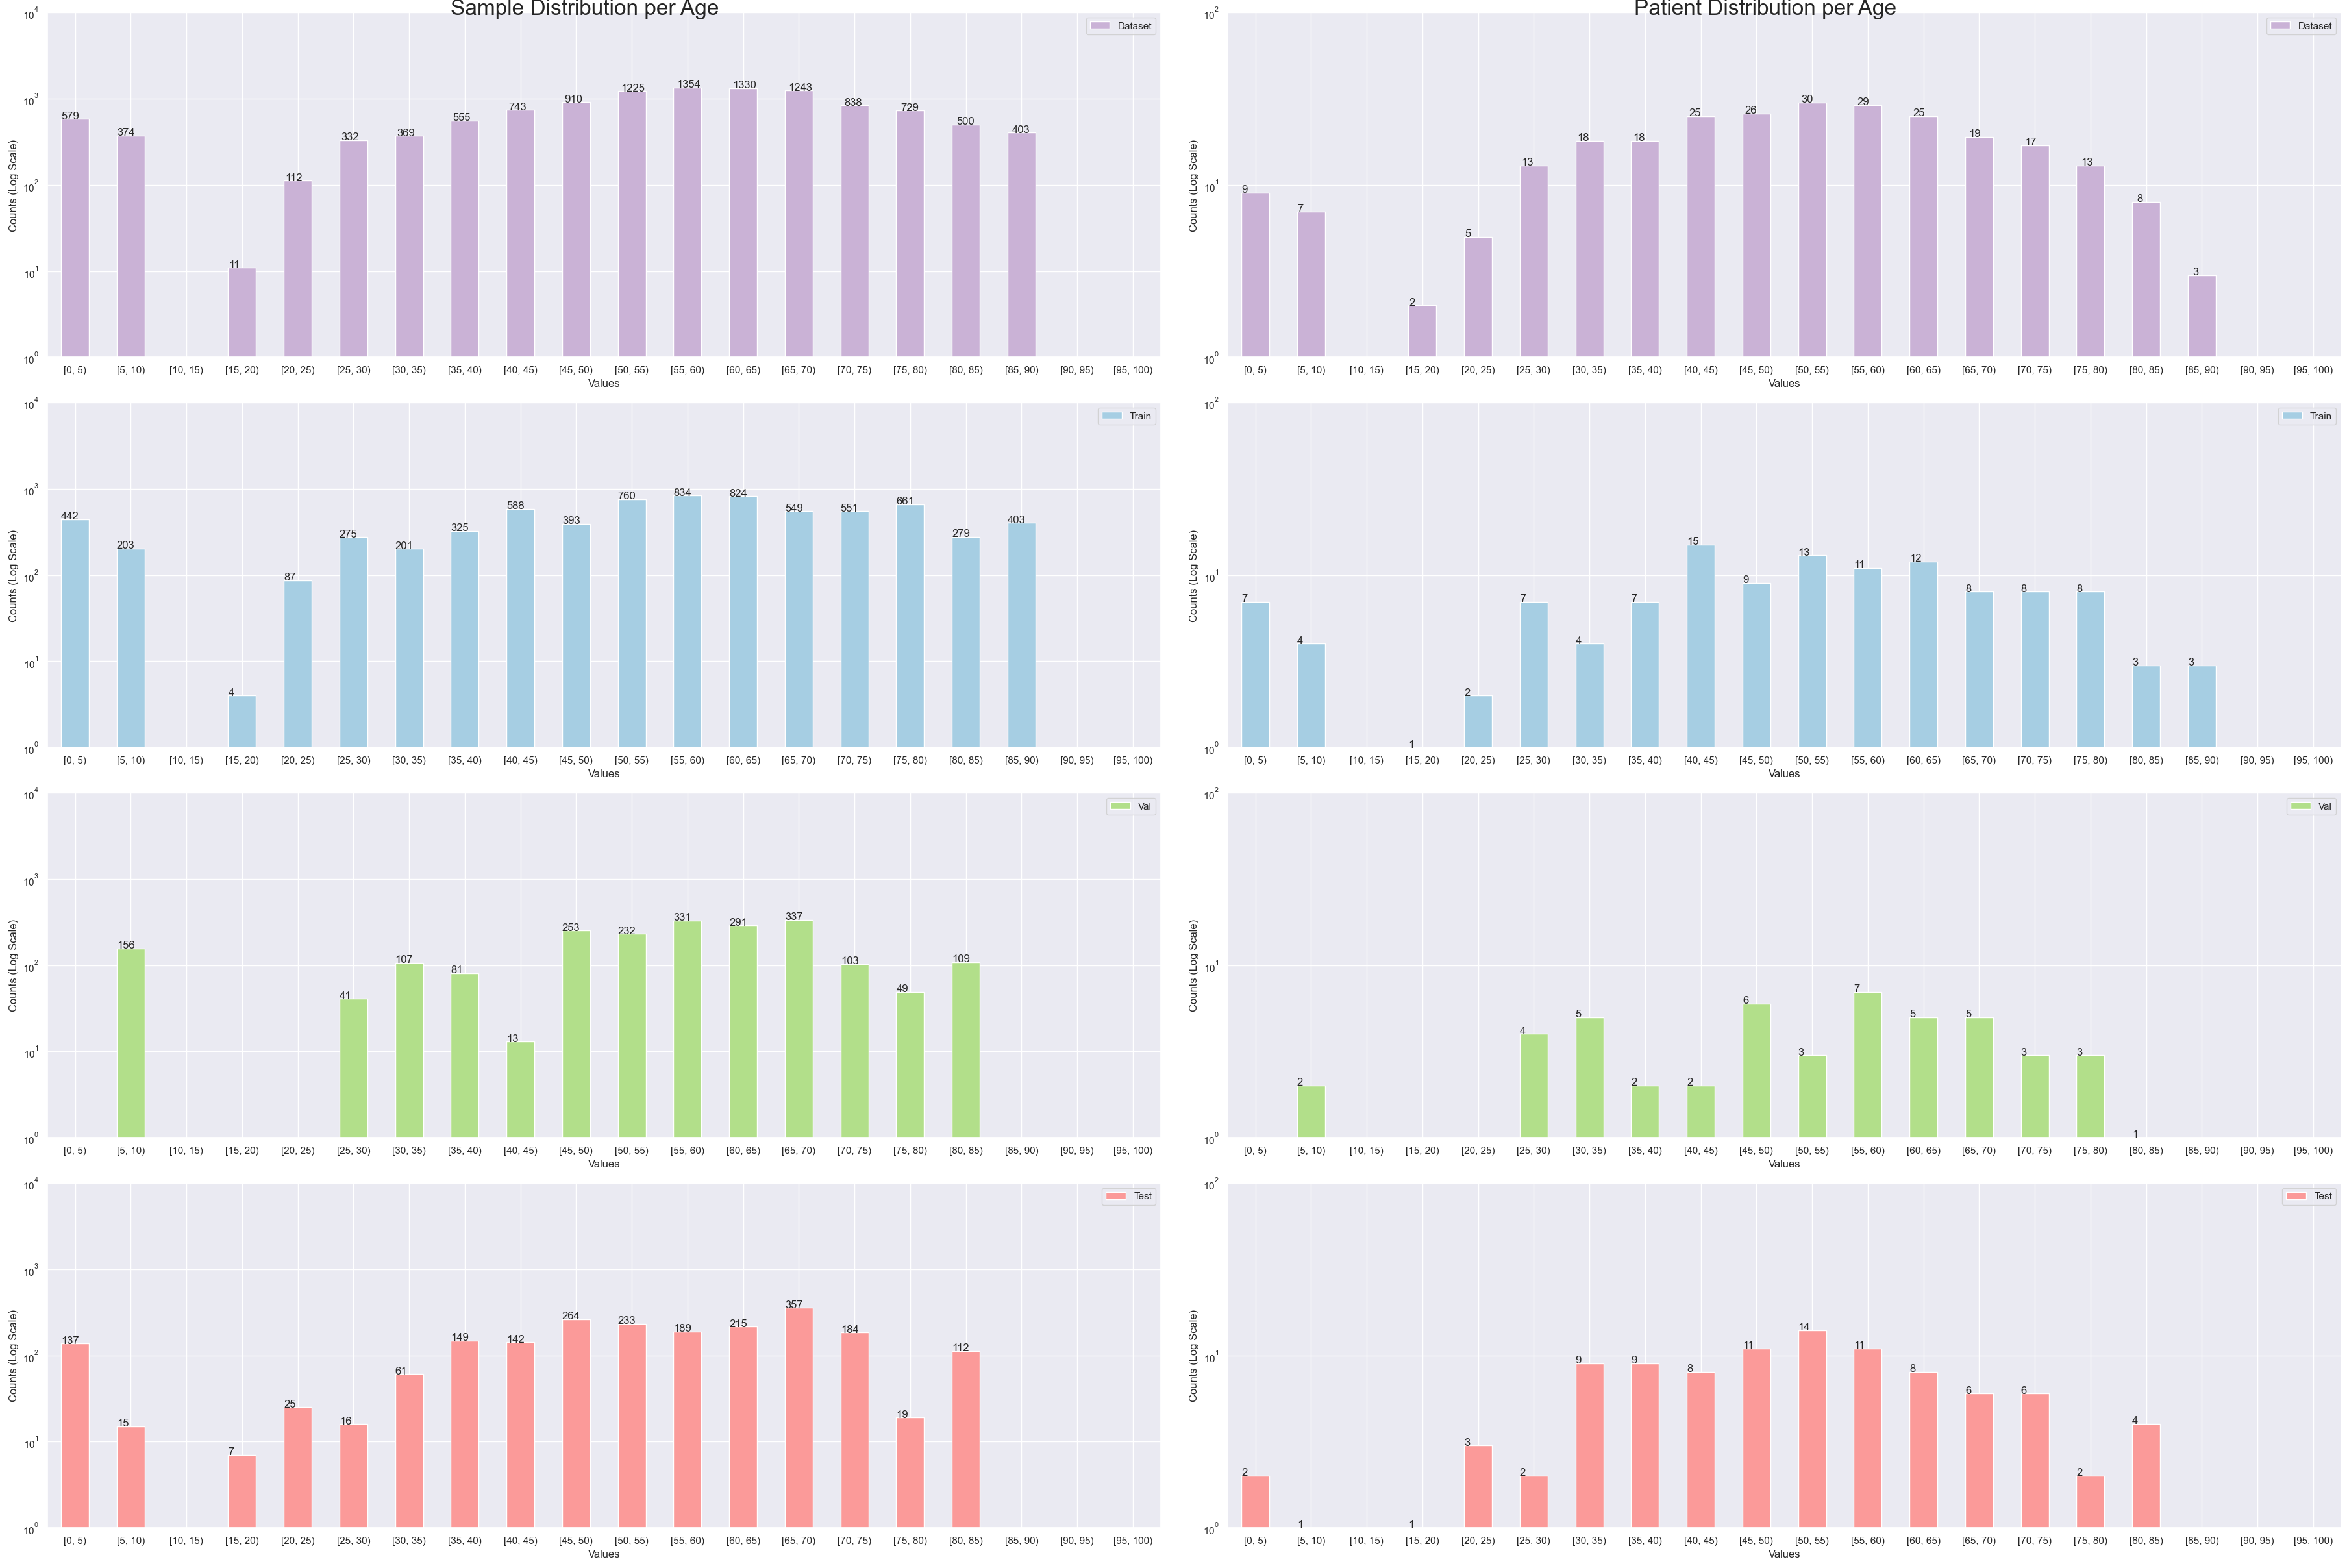

In [12]:
plot.column_as_histograms( samples_df, patient_df, "age", dataset_name, figsize = (36, 24))

In [13]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = True )

Sample Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 [0, 5) 
 579 
 442 
 0 
 137 
 
 
 [5, 10) 
 374 
 203 
 156 
 15 
 
 
 [10, 15) 
 0 
 0 
 0 
 0 
 
 
 [15, 20) 
 11 
 4 
 0 
 7 
 
 
 [20, 25) 
 112 
 87 
 0 
 25 
 
 
 [25, 30) 
 332 
 275 
 41 
 16 
 
 
 [30, 35) 
 369 
 201 
 107 
 61 
 
 
 [35, 40) 
 555 
 325 
 81 
 149 
 
 
 [40, 45) 
 743 
 588 
 13 
 142 
 
 
 [45, 50) 
 910 
 393 
 253 
 264 
 
 
 [50, 55) 
 1225 
 760 
 232 
 233 
 
 
 [55, 60) 
 1354 
 834 
 331 
 189 
 
 
 [60, 65) 
 1330 
 824 
 291 
 215 
 
 
 [65, 70) 
 1243 
 549 
 337 
 357 
 
 
 [70, 75) 
 838 
 551 
 103 
 184 
 
 
 [75, 80) 
 729 
 661 
 49 
 19 
 
 
 [80, 85) 
 500 
 279 
 109 
 112 
 
 
 [85, 90) 
 403 
 403 
 0 
 0 
 
 
 [90, 95) 
 0 
 0 
 0 
 0 
 
 
 [95, 100) 
 0 
 0 
 0 
 0 
 
 
 SUM 
 11607 
 7379 
 2103 
 2125 
 
 
 Patient Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 [0, 5) 
 9 
 7 
 0 
 2 
 
 
 [5, 10) 
 7 
 4 
 2 
 1 
 
 
 [10, 15) 
 0 
 0 
 0 
 0 
 
 
 [15, 20) 
 2 
 1 
 0 
 1 
 
 
 [20, 25) 
 5 
 2 
 0 
 3 
 
 
 [25, 30) 
 13 
 7 
 4 
 2 
 
 
 [30, 35) 
 18 
 4 
 5 
 9 
 
 
 [35, 40) 
 18 
 7 
 2 
 9 
 
 
 [40, 45) 
 25 
 15 
 2 
 8 
 
 
 [45, 50) 
 26 
 9 
 6 
 11 
 
 
 [50, 55) 
 30 
 13 
 3 
 14 
 
 
 [55, 60) 
 29 
 11 
 7 
 11 
 
 
 [60, 65) 
 25 
 12 
 5 
 8 
 
 
 [65, 70) 
 19 
 8 
 5 
 6 
 
 
 [70, 75) 
 17 
 8 
 3 
 6 
 
 
 [75, 80) 
 13 
 8 
 3 
 2 
 
 
 [80, 85) 
 8 
 3 
 1 
 4 
 
 
 [85, 90) 
 3 
 3 
 0 
 0 
 
 
 [90, 95) 
 0 
 0 
 0 
 0 
 
 
 [95, 100) 
 0 
 0 
 0 
 0 
 
 
 SUM 
 267 
 122 
 48 
 97

## Sex

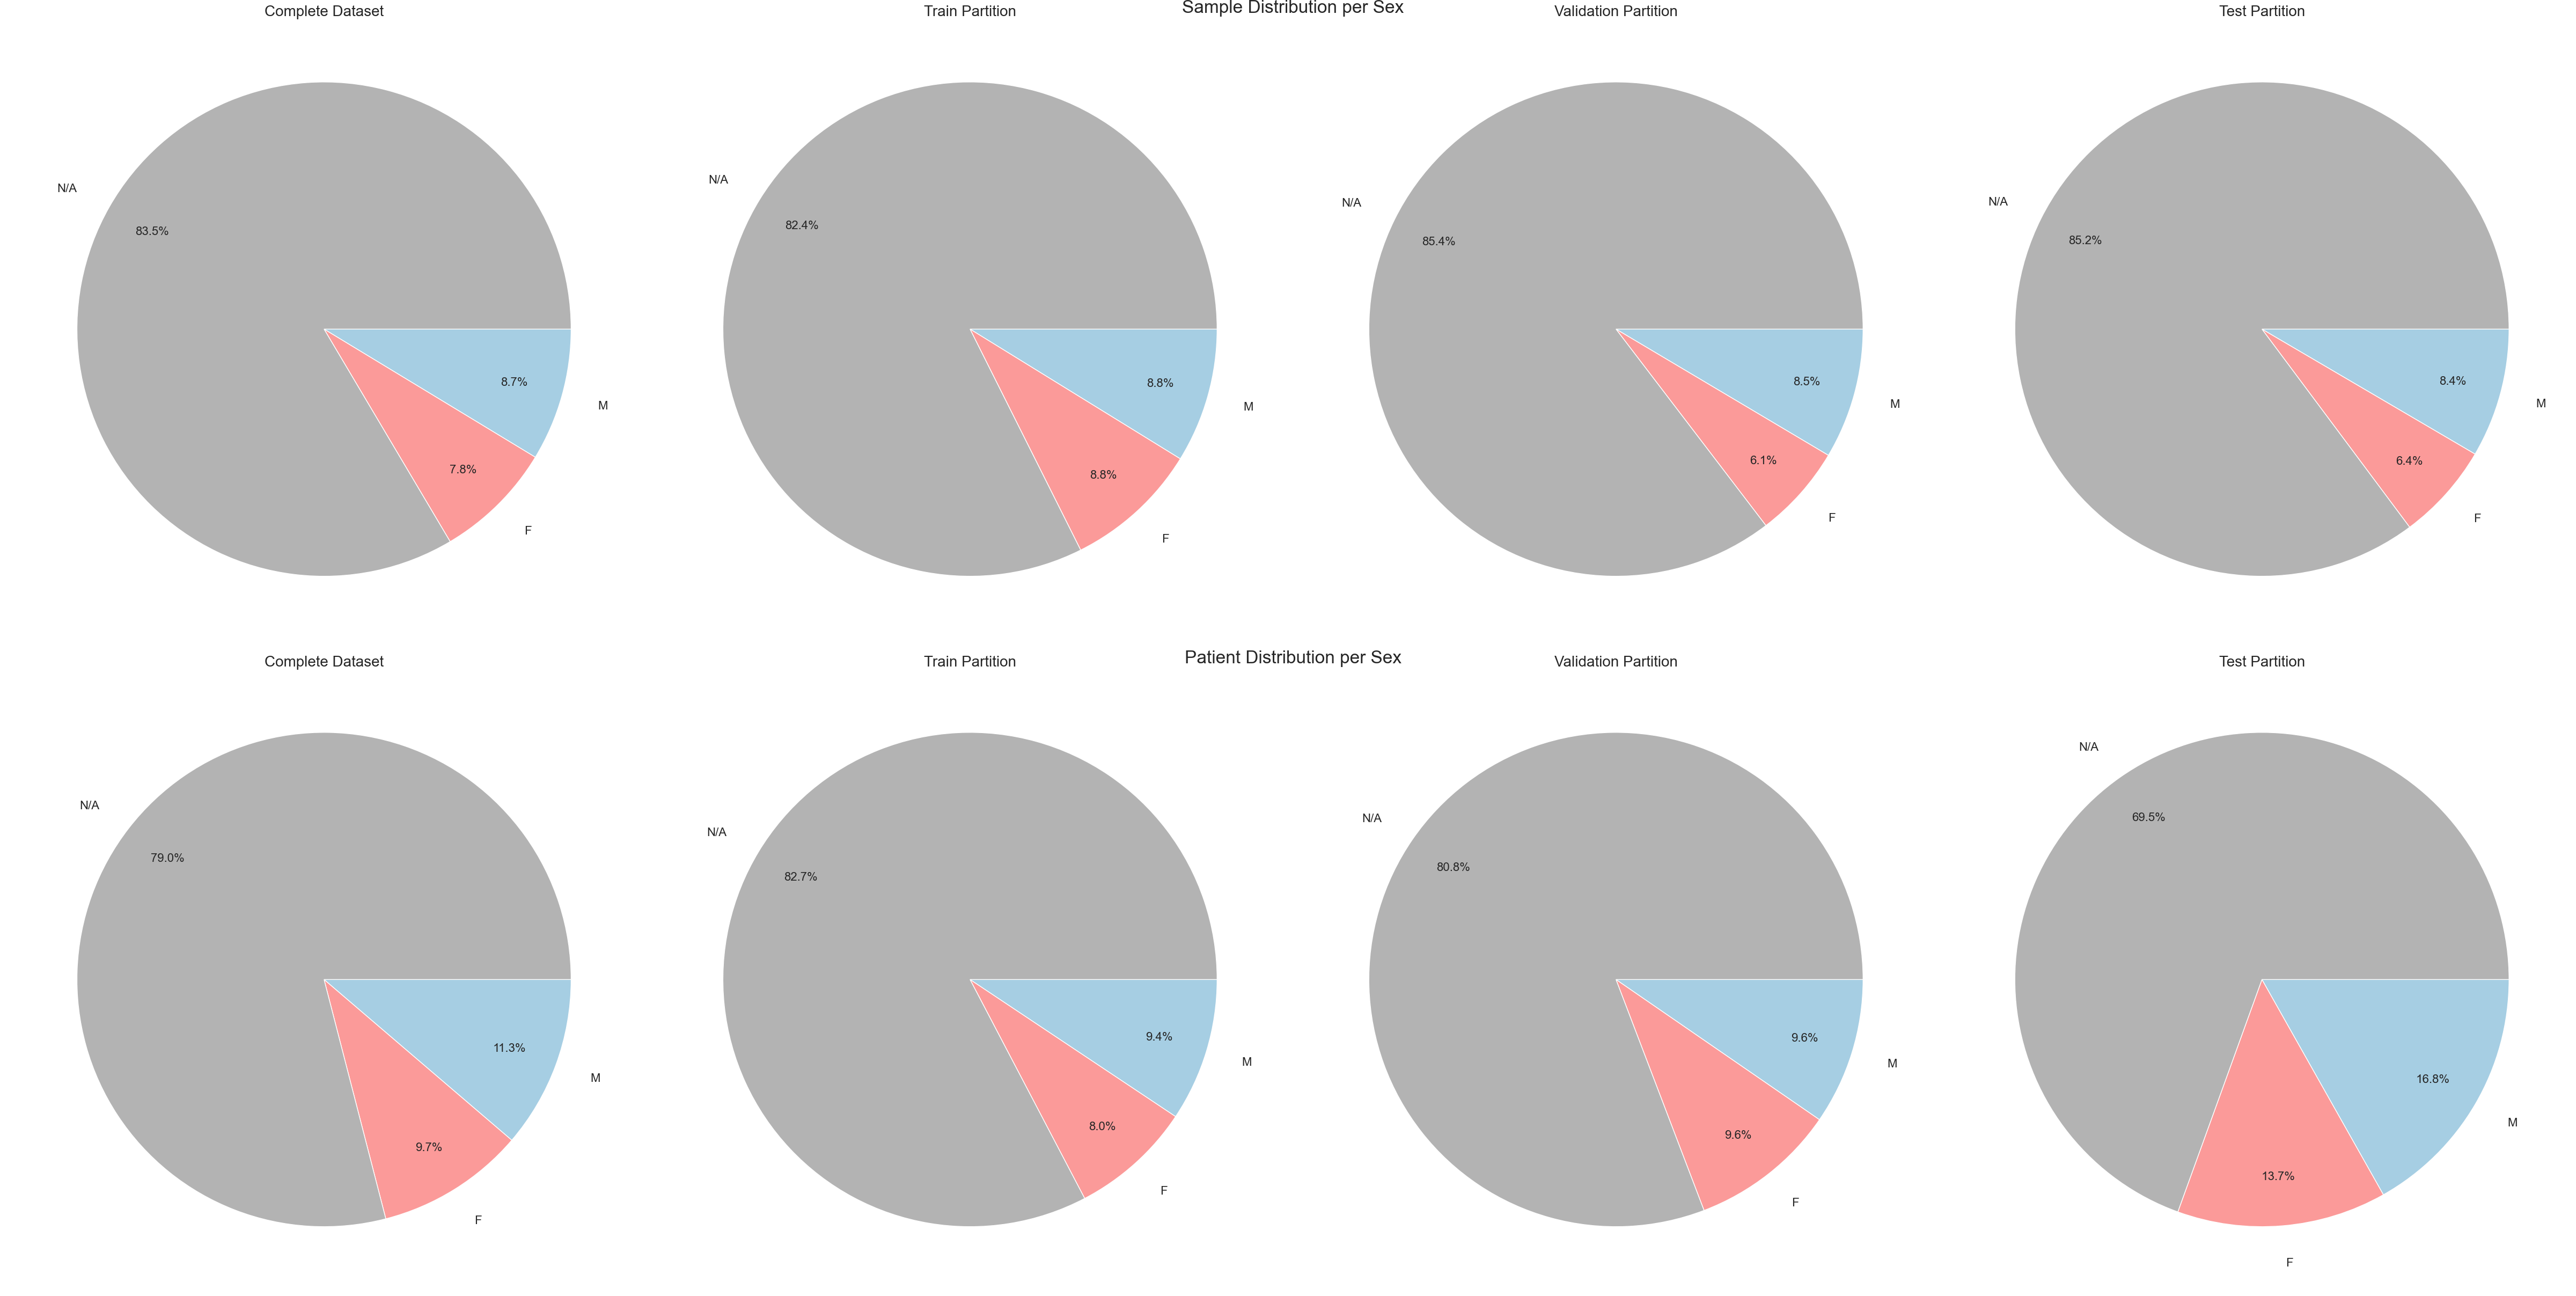

In [14]:
plot.column_as_pies( samples_df, patient_df, "sex", dataset_name, figsize = (48, 24) )

In [15]:
plot.column_as_table( samples_df, patient_df, "sex", dataset_name, bin_flag = False )

Sample Distribution
 by Sex 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 61434 
 36860 
 12279 
 12295 
 
 
 M 
 6380 
 3935 
 1227 
 1218 
 
 
 F 
 5737 
 3943 
 876 
 918 
 
 
 SUM 
 73551 
 44738 
 14382 
 14431 
 
 
 Patient Distribution
 by Sex 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 1017 
 592 
 202 
 223 
 
 
 F 
 125 
 57 
 24 
 44 
 
 
 M 
 145 
 67 
 24 
 54 
 
 
 SUM 
 1287 
 716 
 250 
 321

## Country

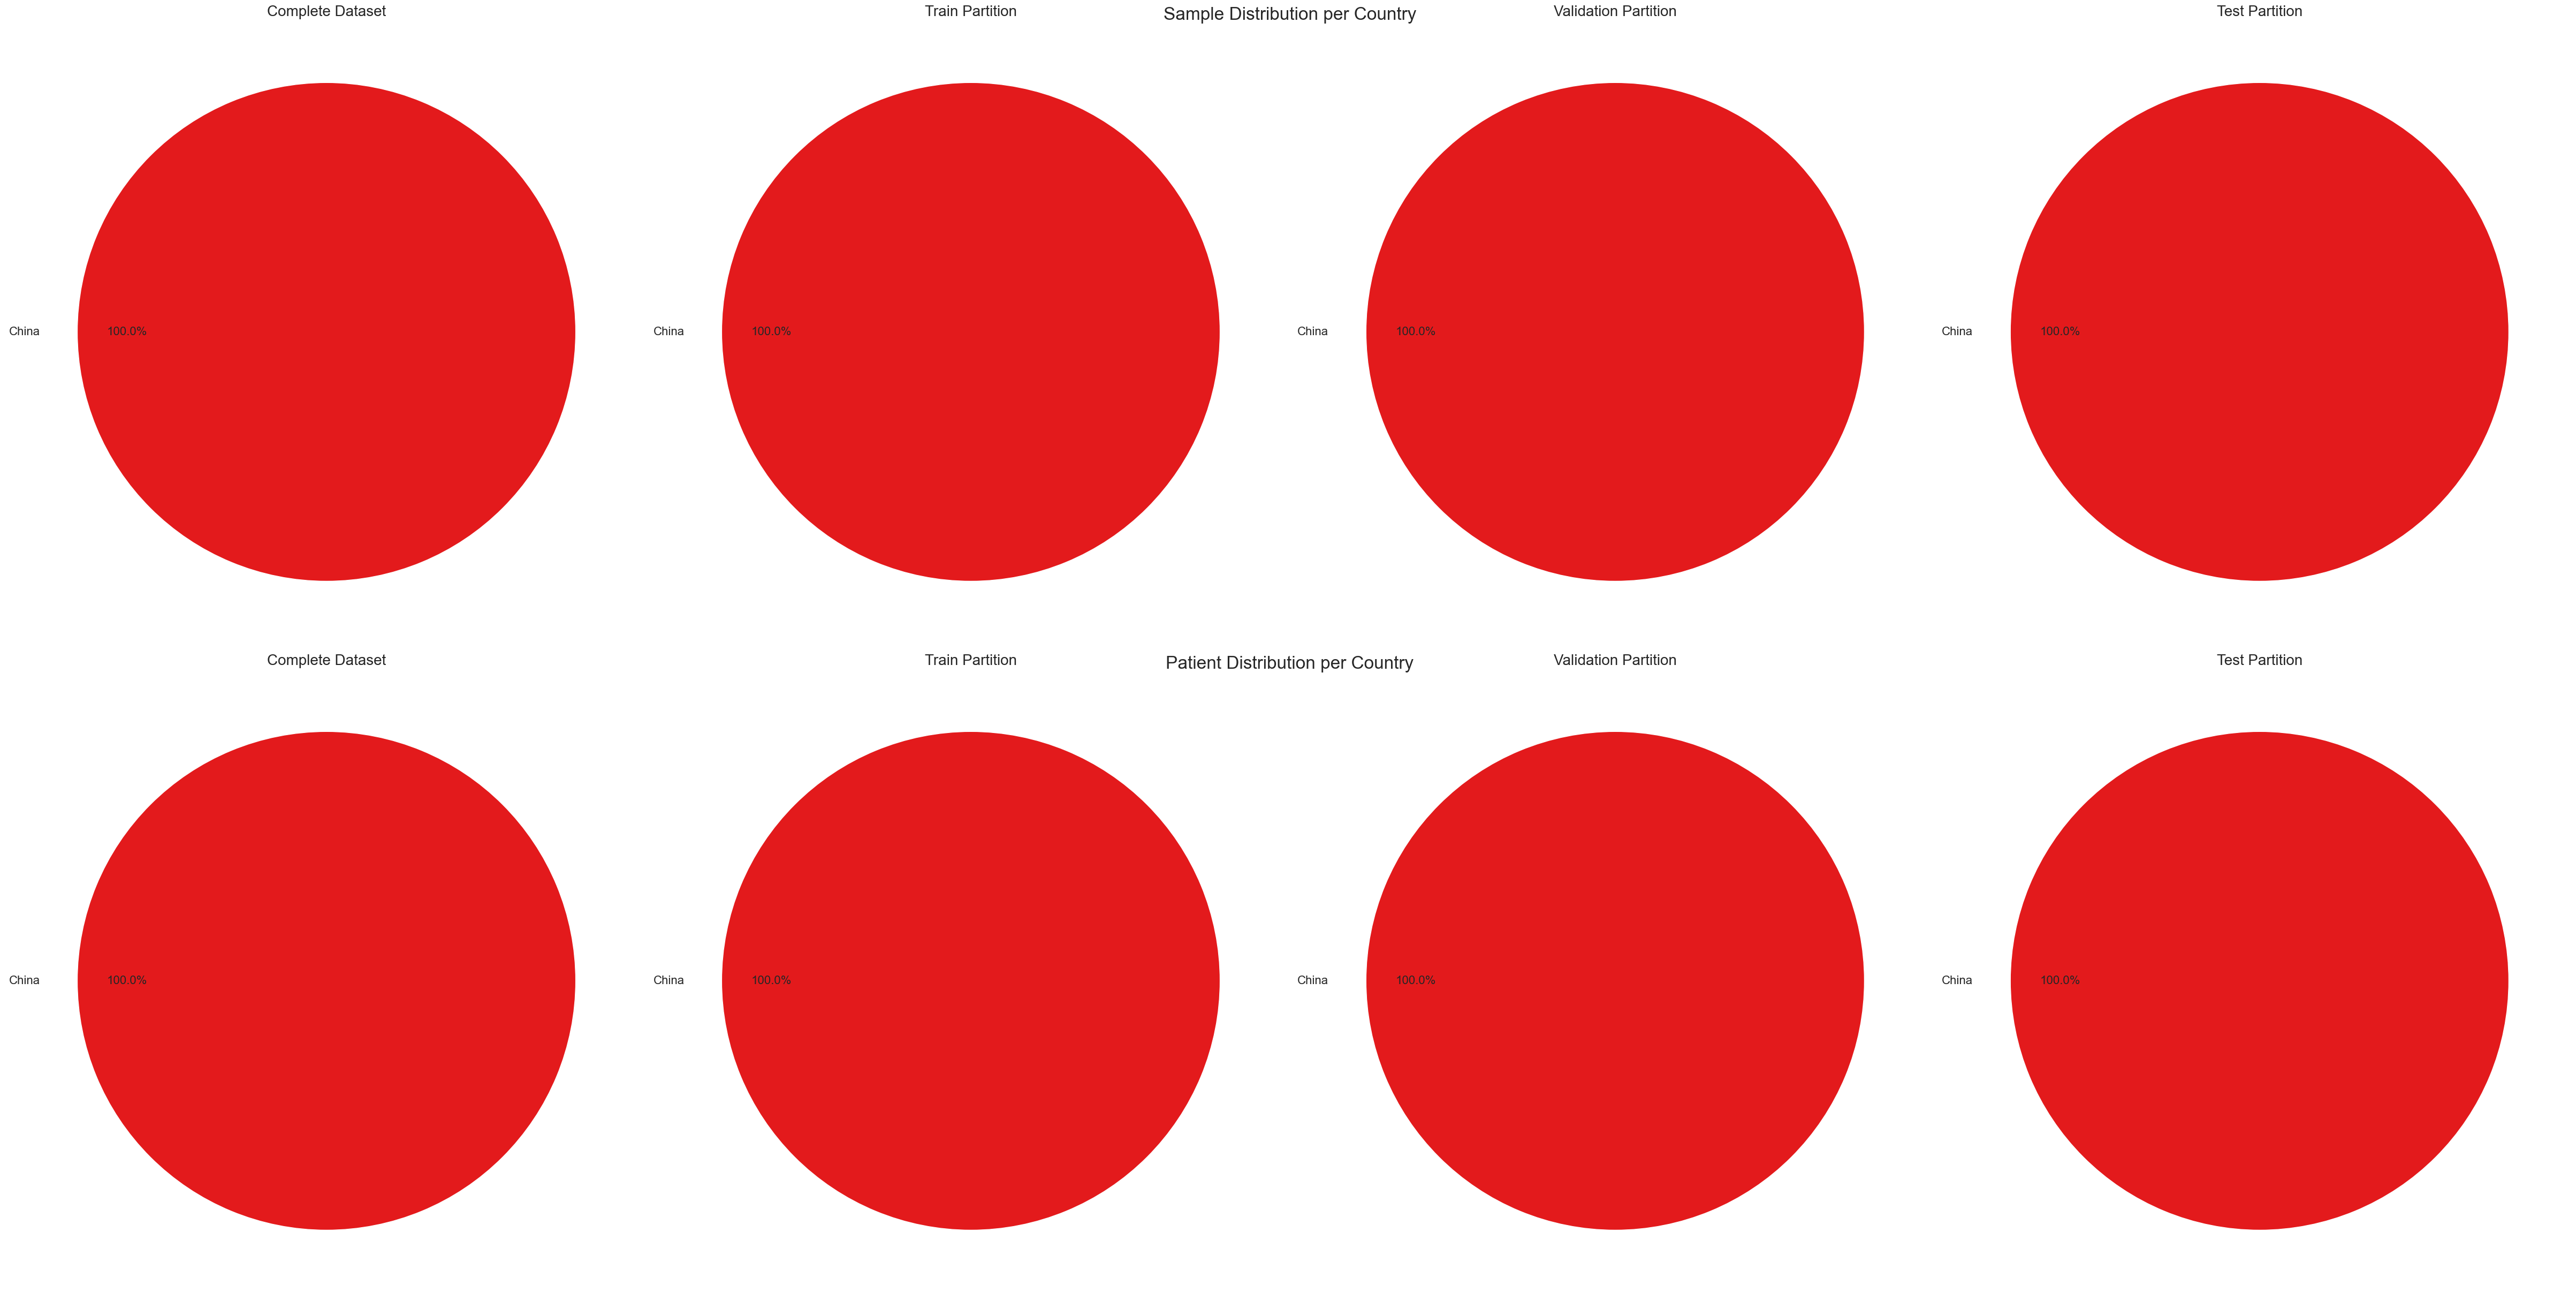

In [16]:
plot.column_as_pies( samples_df, patient_df, "country", dataset_name, figsize = (48, 24) )

In [17]:
plot.column_as_table( samples_df, patient_df, "country", dataset_name, bin_flag = False )

Sample Distribution
 by Country 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 China 
 73551 
 44738 
 14382 
 14431 
 
 
 SUM 
 73551 
 44738 
 14382 
 14431 
 
 
 Patient Distribution
 by Country 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 China 
 1287 
 716 
 250 
 321 
 
 
 SUM 
 1287 
 716 
 250 
 321

## Partition

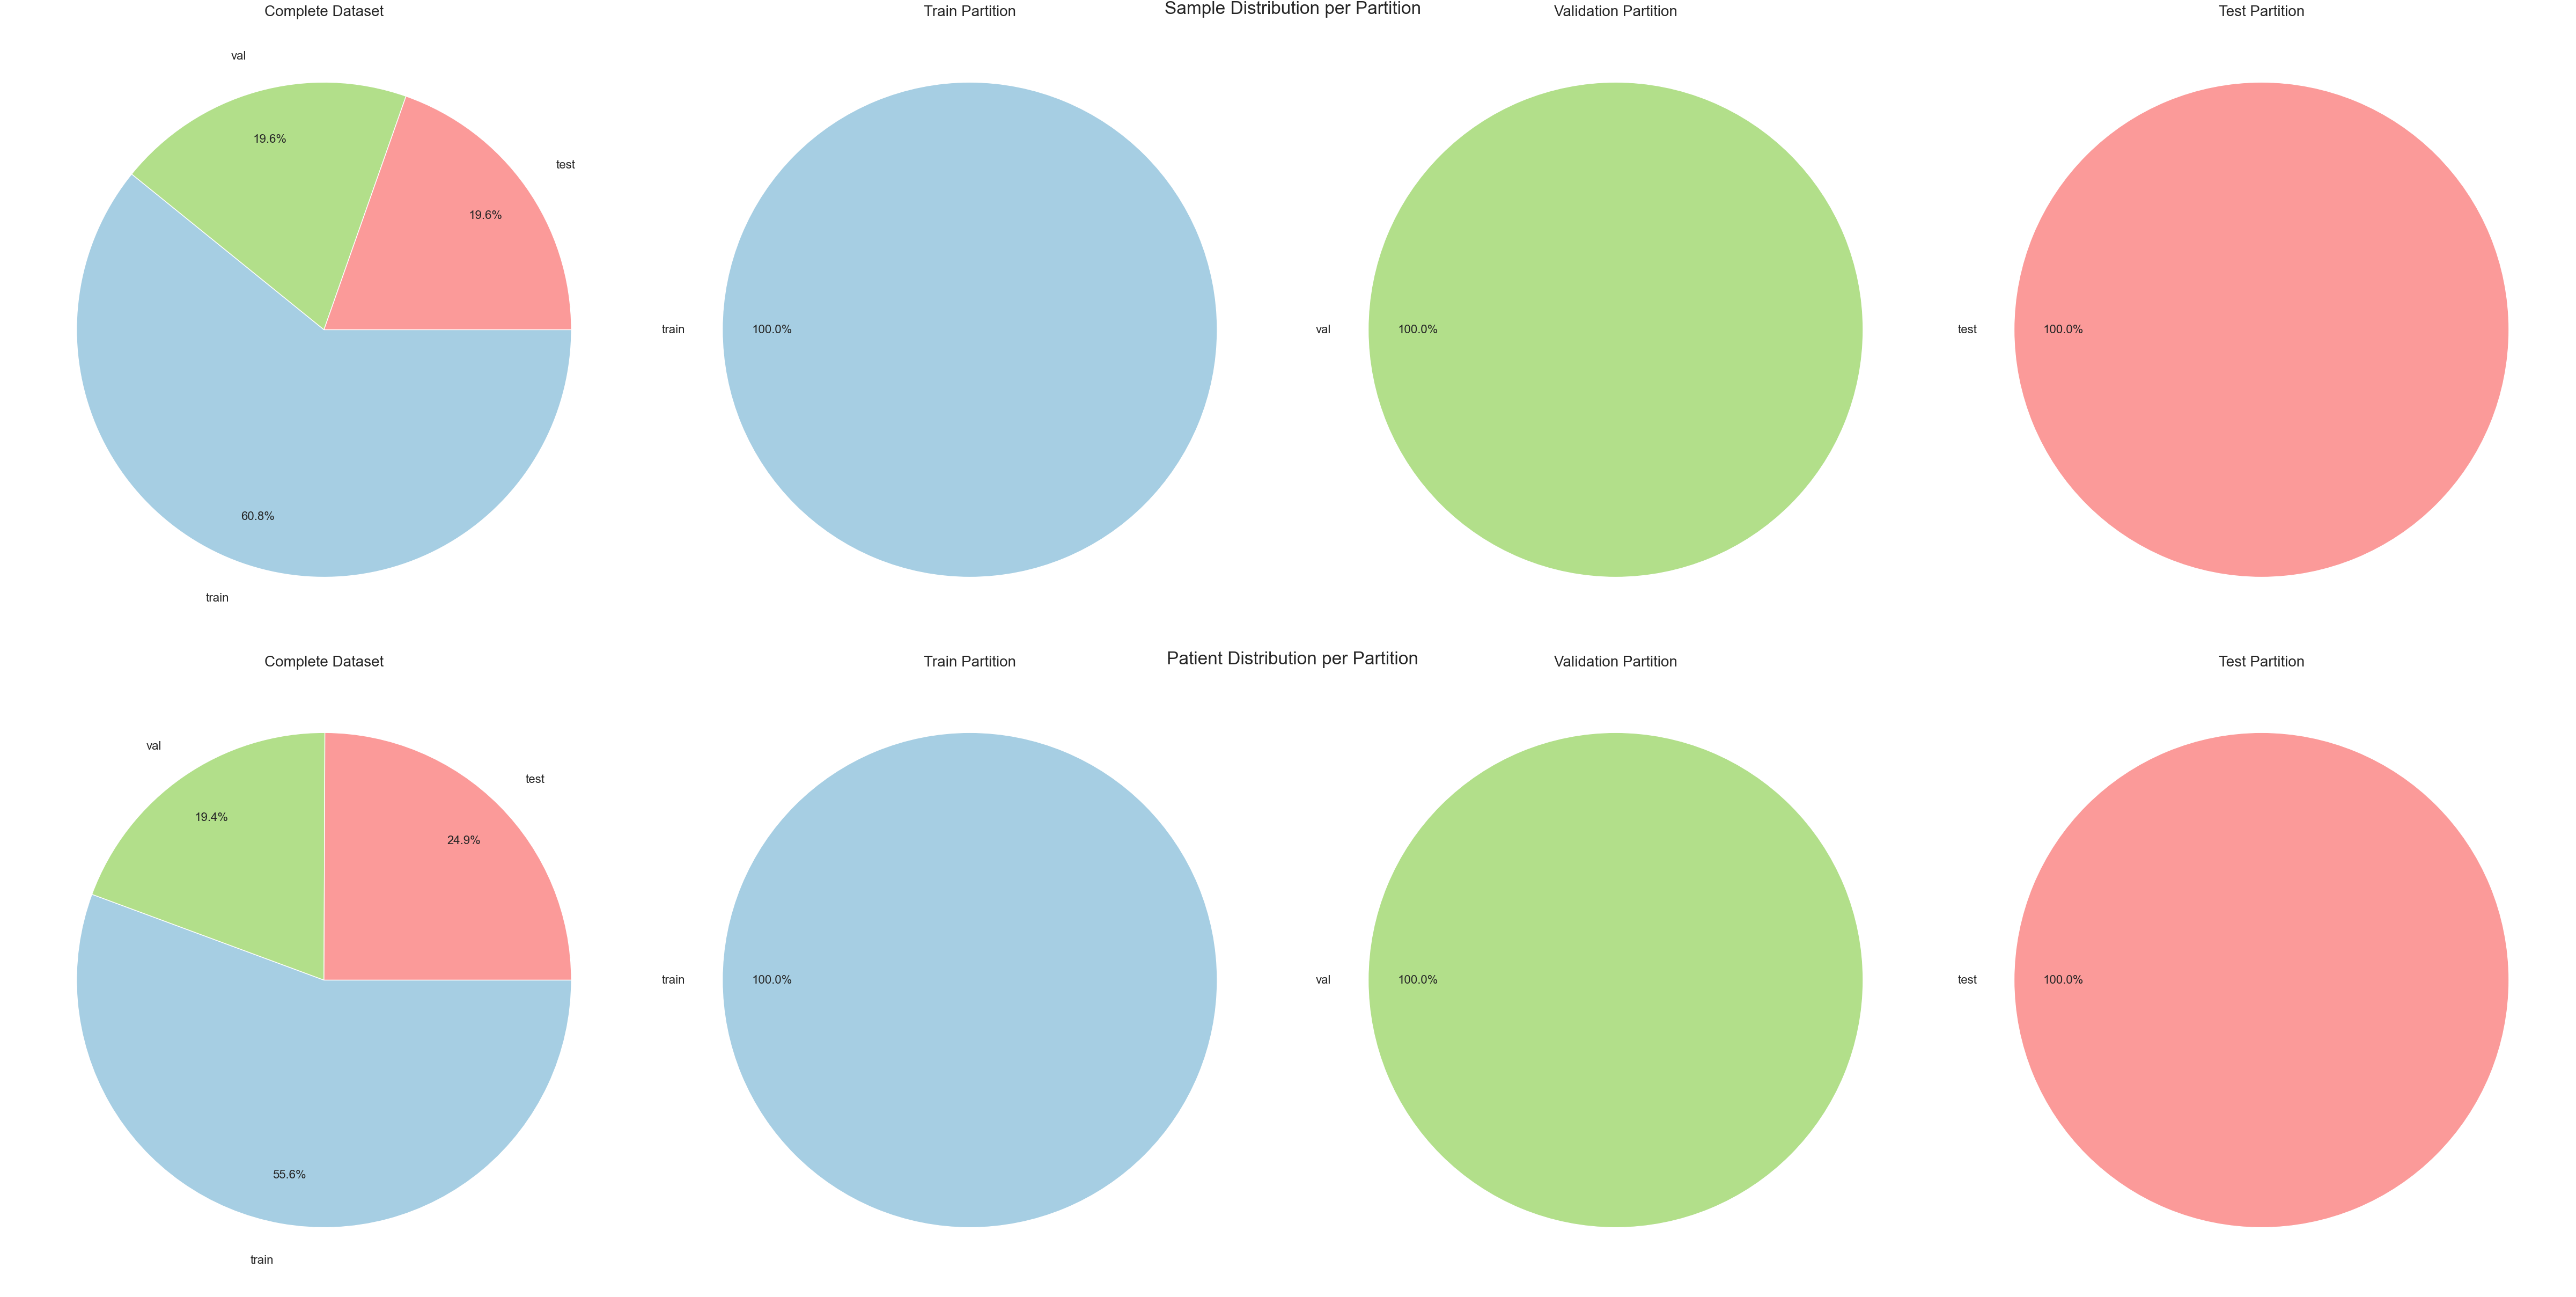

In [18]:
plot.column_as_pies( samples_df, patient_df, "partition", dataset_name, figsize = (48, 24) )

In [19]:
plot.column_as_table( samples_df, patient_df, "partition", dataset_name, bin_flag = False )

Sample Distribution
 by Partition 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 train 
 44738 
 44738 
 0 
 0 
 
 
 test 
 14431 
 0 
 0 
 14431 
 
 
 val 
 14382 
 0 
 14382 
 0 
 
 
 SUM 
 73551 
 44738 
 14382 
 14431 
 
 
 Patient Distribution
 by Partition 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 train 
 716 
 716 
 0 
 0 
 
 
 test 
 321 
 0 
 0 
 321 
 
 
 val 
 250 
 0 
 250 
 0 
 
 
 SUM 
 1287 
 716 
 250 
 321

## Slice Selection

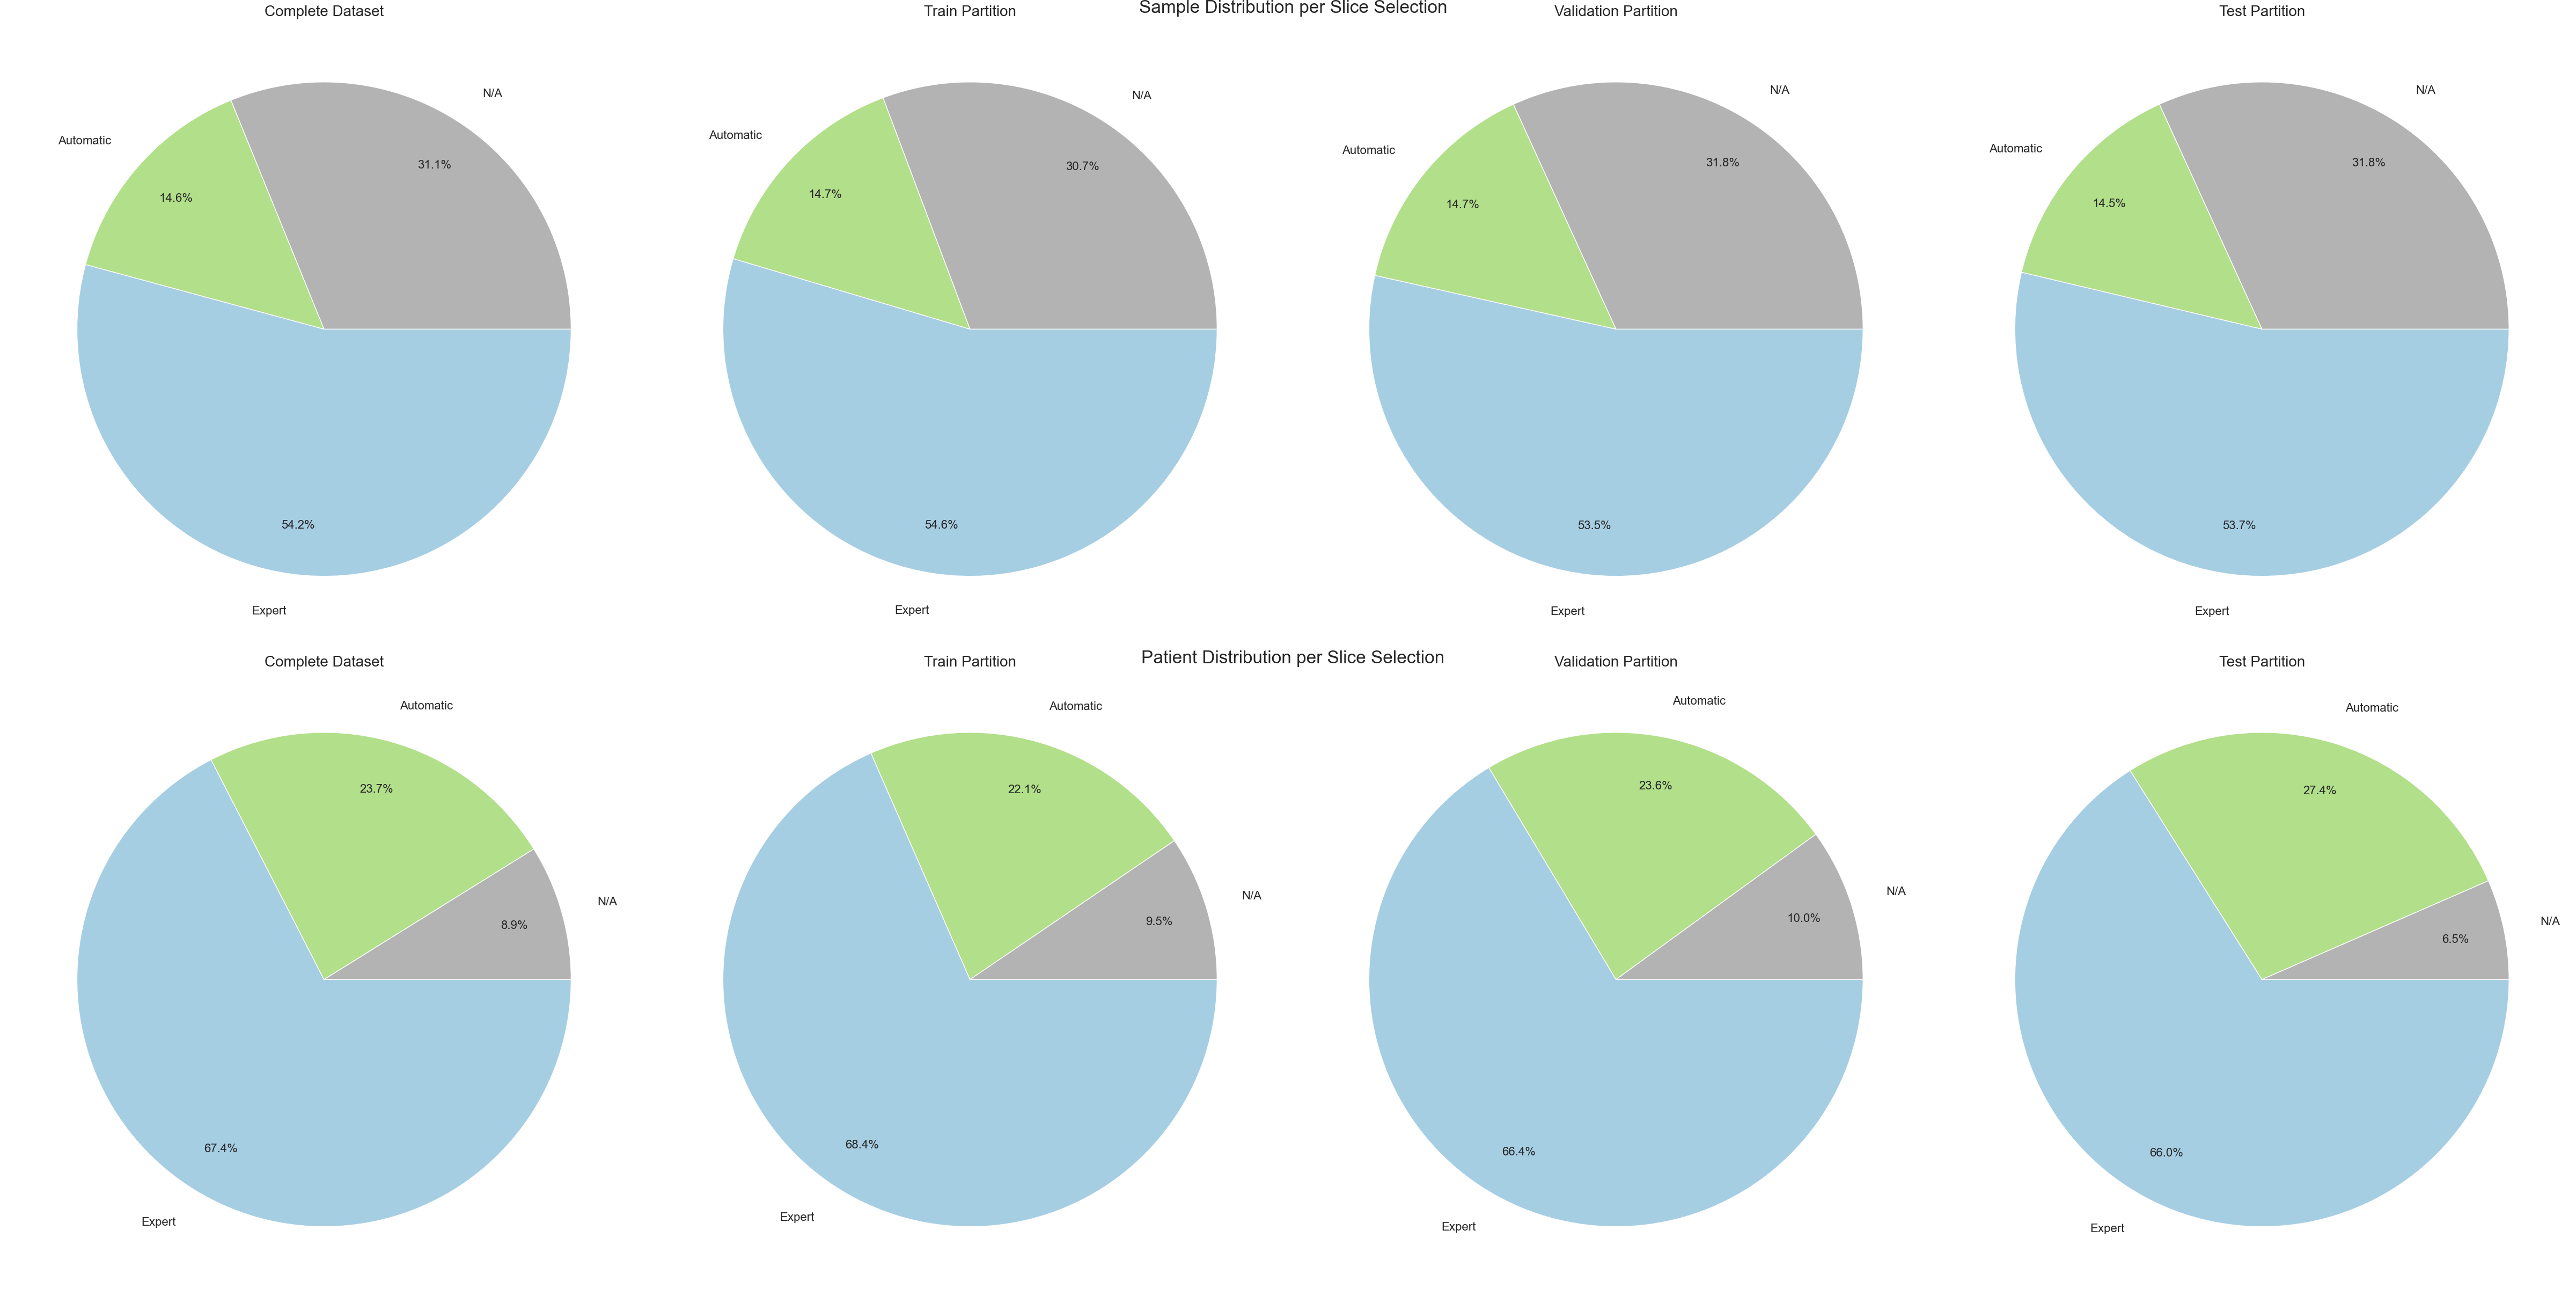

In [20]:
plot.column_as_pies( samples_df, patient_df, "slice_selection", dataset_name, figsize = (48, 24) )

In [21]:
plot.column_as_table( samples_df, patient_df, "slice_selection", dataset_name, bin_flag = False )

Sample Distribution
 by Slice Selection 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 Expert 
 39871 
 24429 
 7693 
 7749 
 
 
 Automatic 
 10771 
 6565 
 2114 
 2092 
 
 
 N/A 
 22909 
 13744 
 4575 
 4590 
 
 
 SUM 
 73551 
 44738 
 14382 
 14431 
 
 
 Patient Distribution
 by Slice Selection 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 Expert 
 868 
 490 
 166 
 212 
 
 
 Automatic 
 305 
 158 
 59 
 88 
 
 
 N/A 
 114 
 68 
 25 
 21 
 
 
 SUM 
 1287 
 716 
 250 
 321

# Plots of Comp_CNCB_iCTCF_b

In [22]:
dataset_name = "Comp_CNCB_iCTCF"

## Class

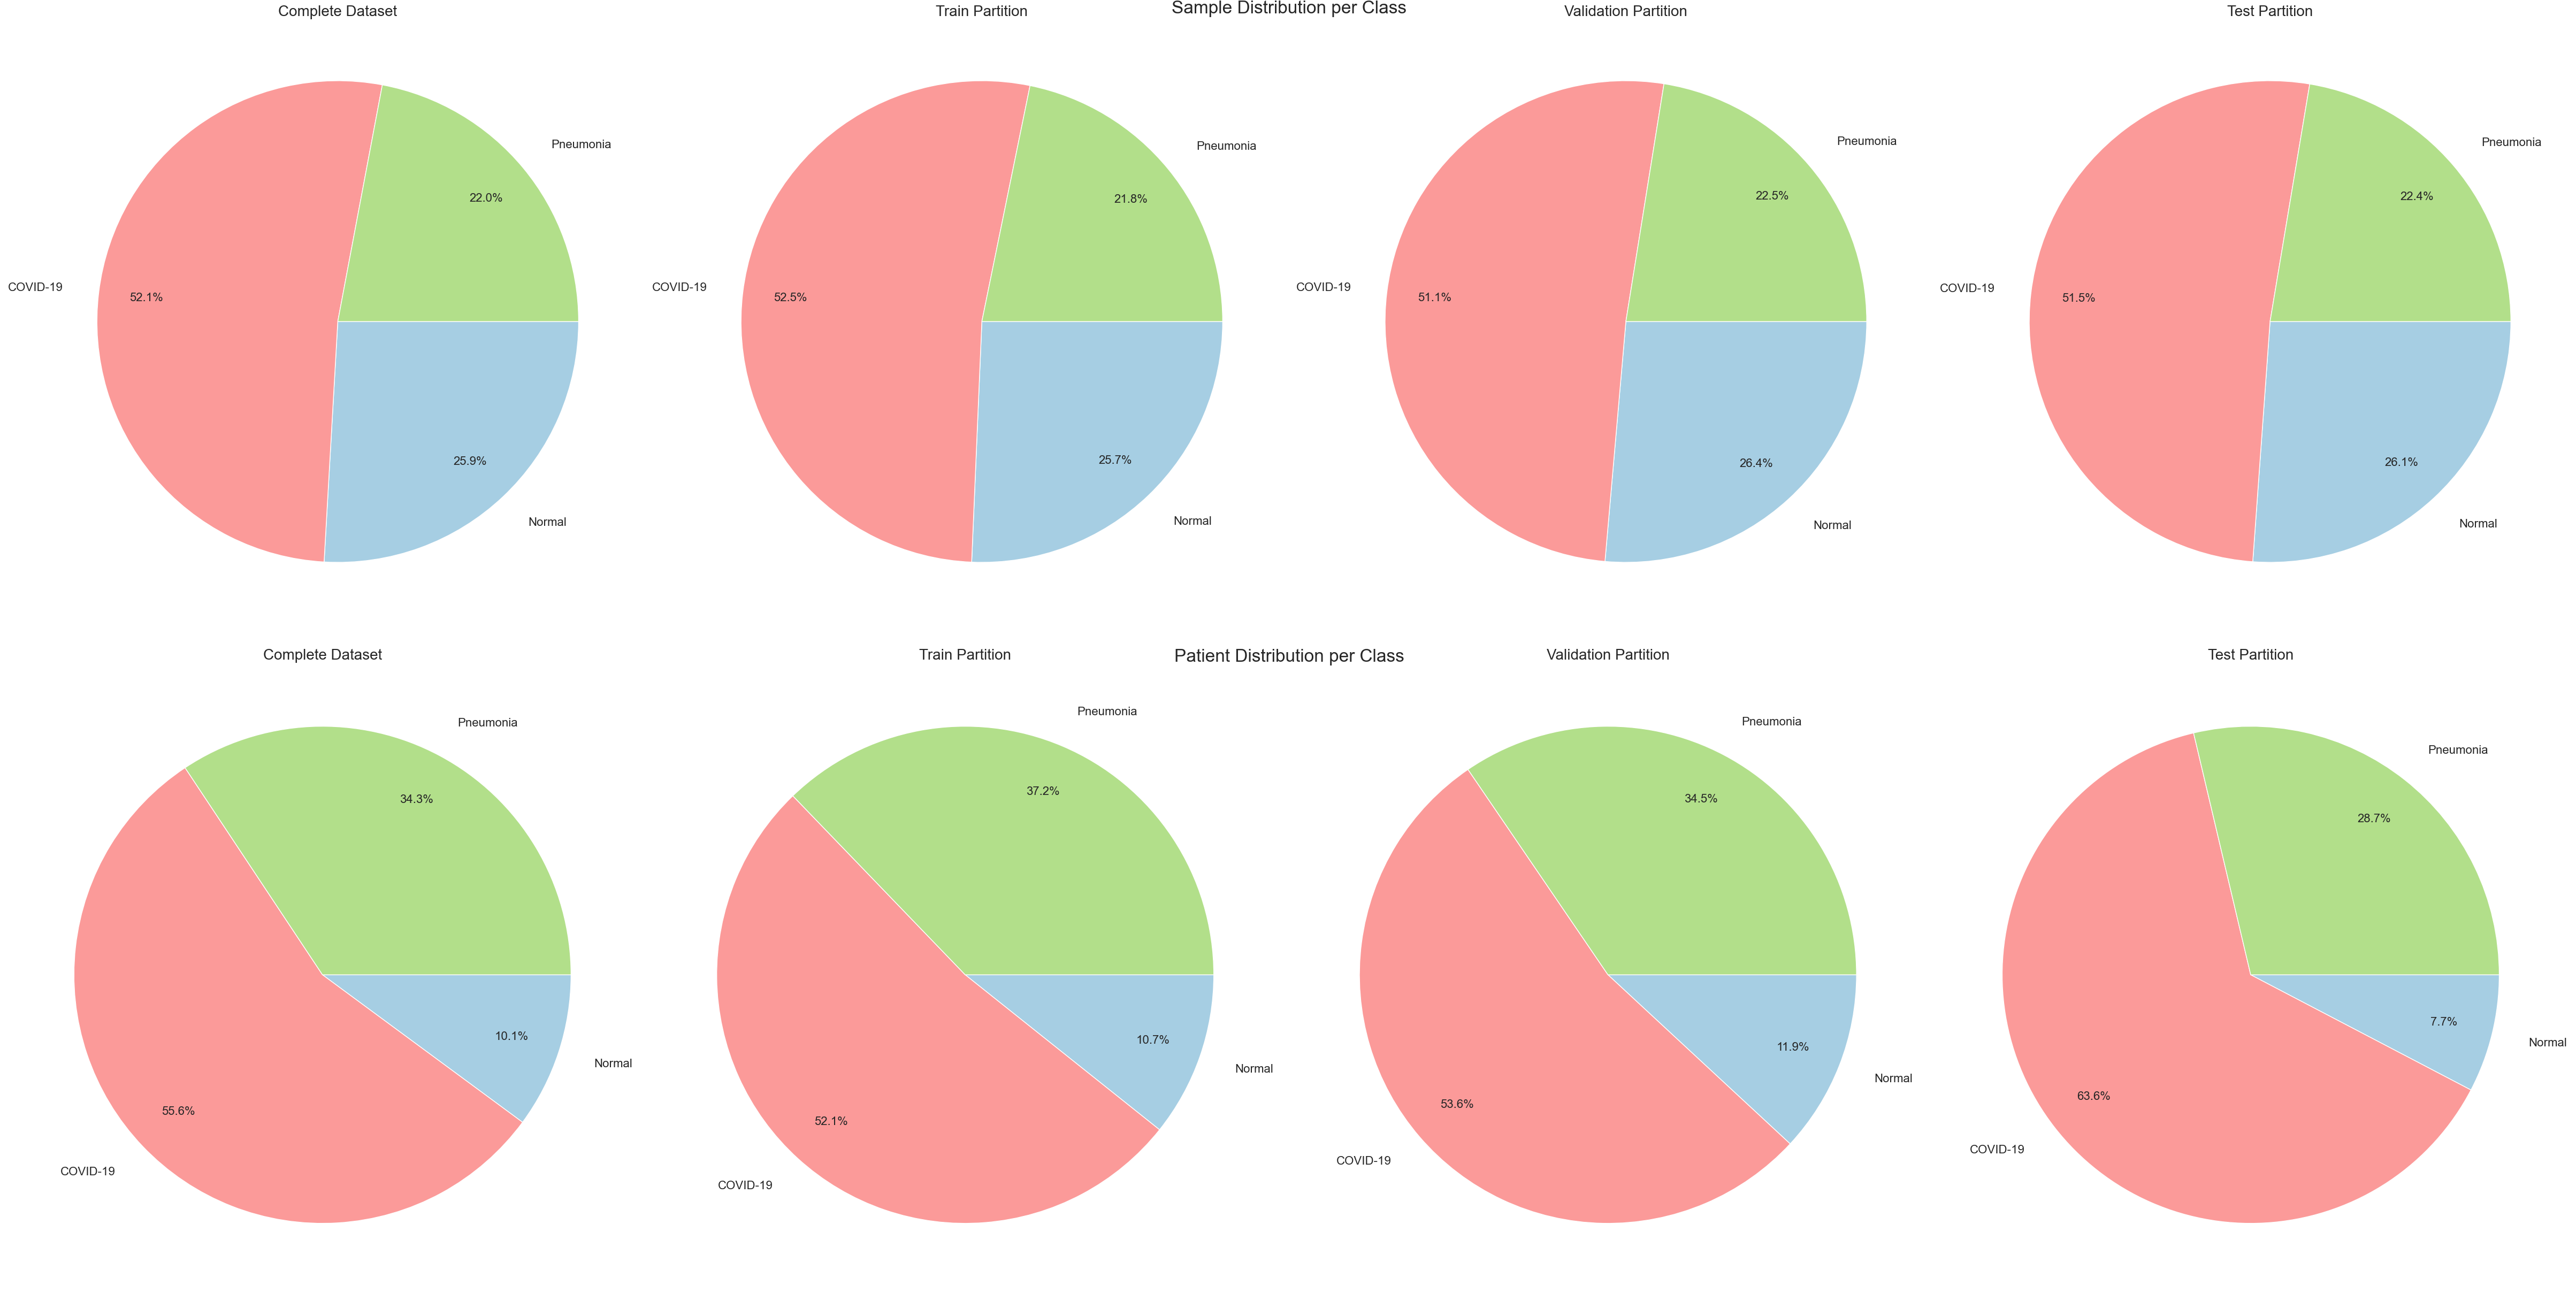

In [23]:
plot.column_as_pies( samples_df, patient_df, "class", dataset_name, figsize = (48, 24) )

In [24]:
plot.column_as_table( samples_df, patient_df, "class", dataset_name, bin_flag = False )

Sample Distribution
 by Class 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 COVID-19 
 45912 
 28116 
 8847 
 8949 
 
 
 Normal 
 22849 
 13741 
 4564 
 4544 
 
 
 Pneumonia 
 19437 
 11663 
 3887 
 3887 
 
 
 SUM 
 88198 
 53520 
 17298 
 17380 
 
 
 Patient Distribution
 by Class 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 COVID-19 
 709 
 350 
 135 
 224 
 
 
 Pneumonia 
 438 
 250 
 87 
 101 
 
 
 Normal 
 129 
 72 
 30 
 27 
 
 
 SUM 
 1276 
 672 
 252 
 352

## Age

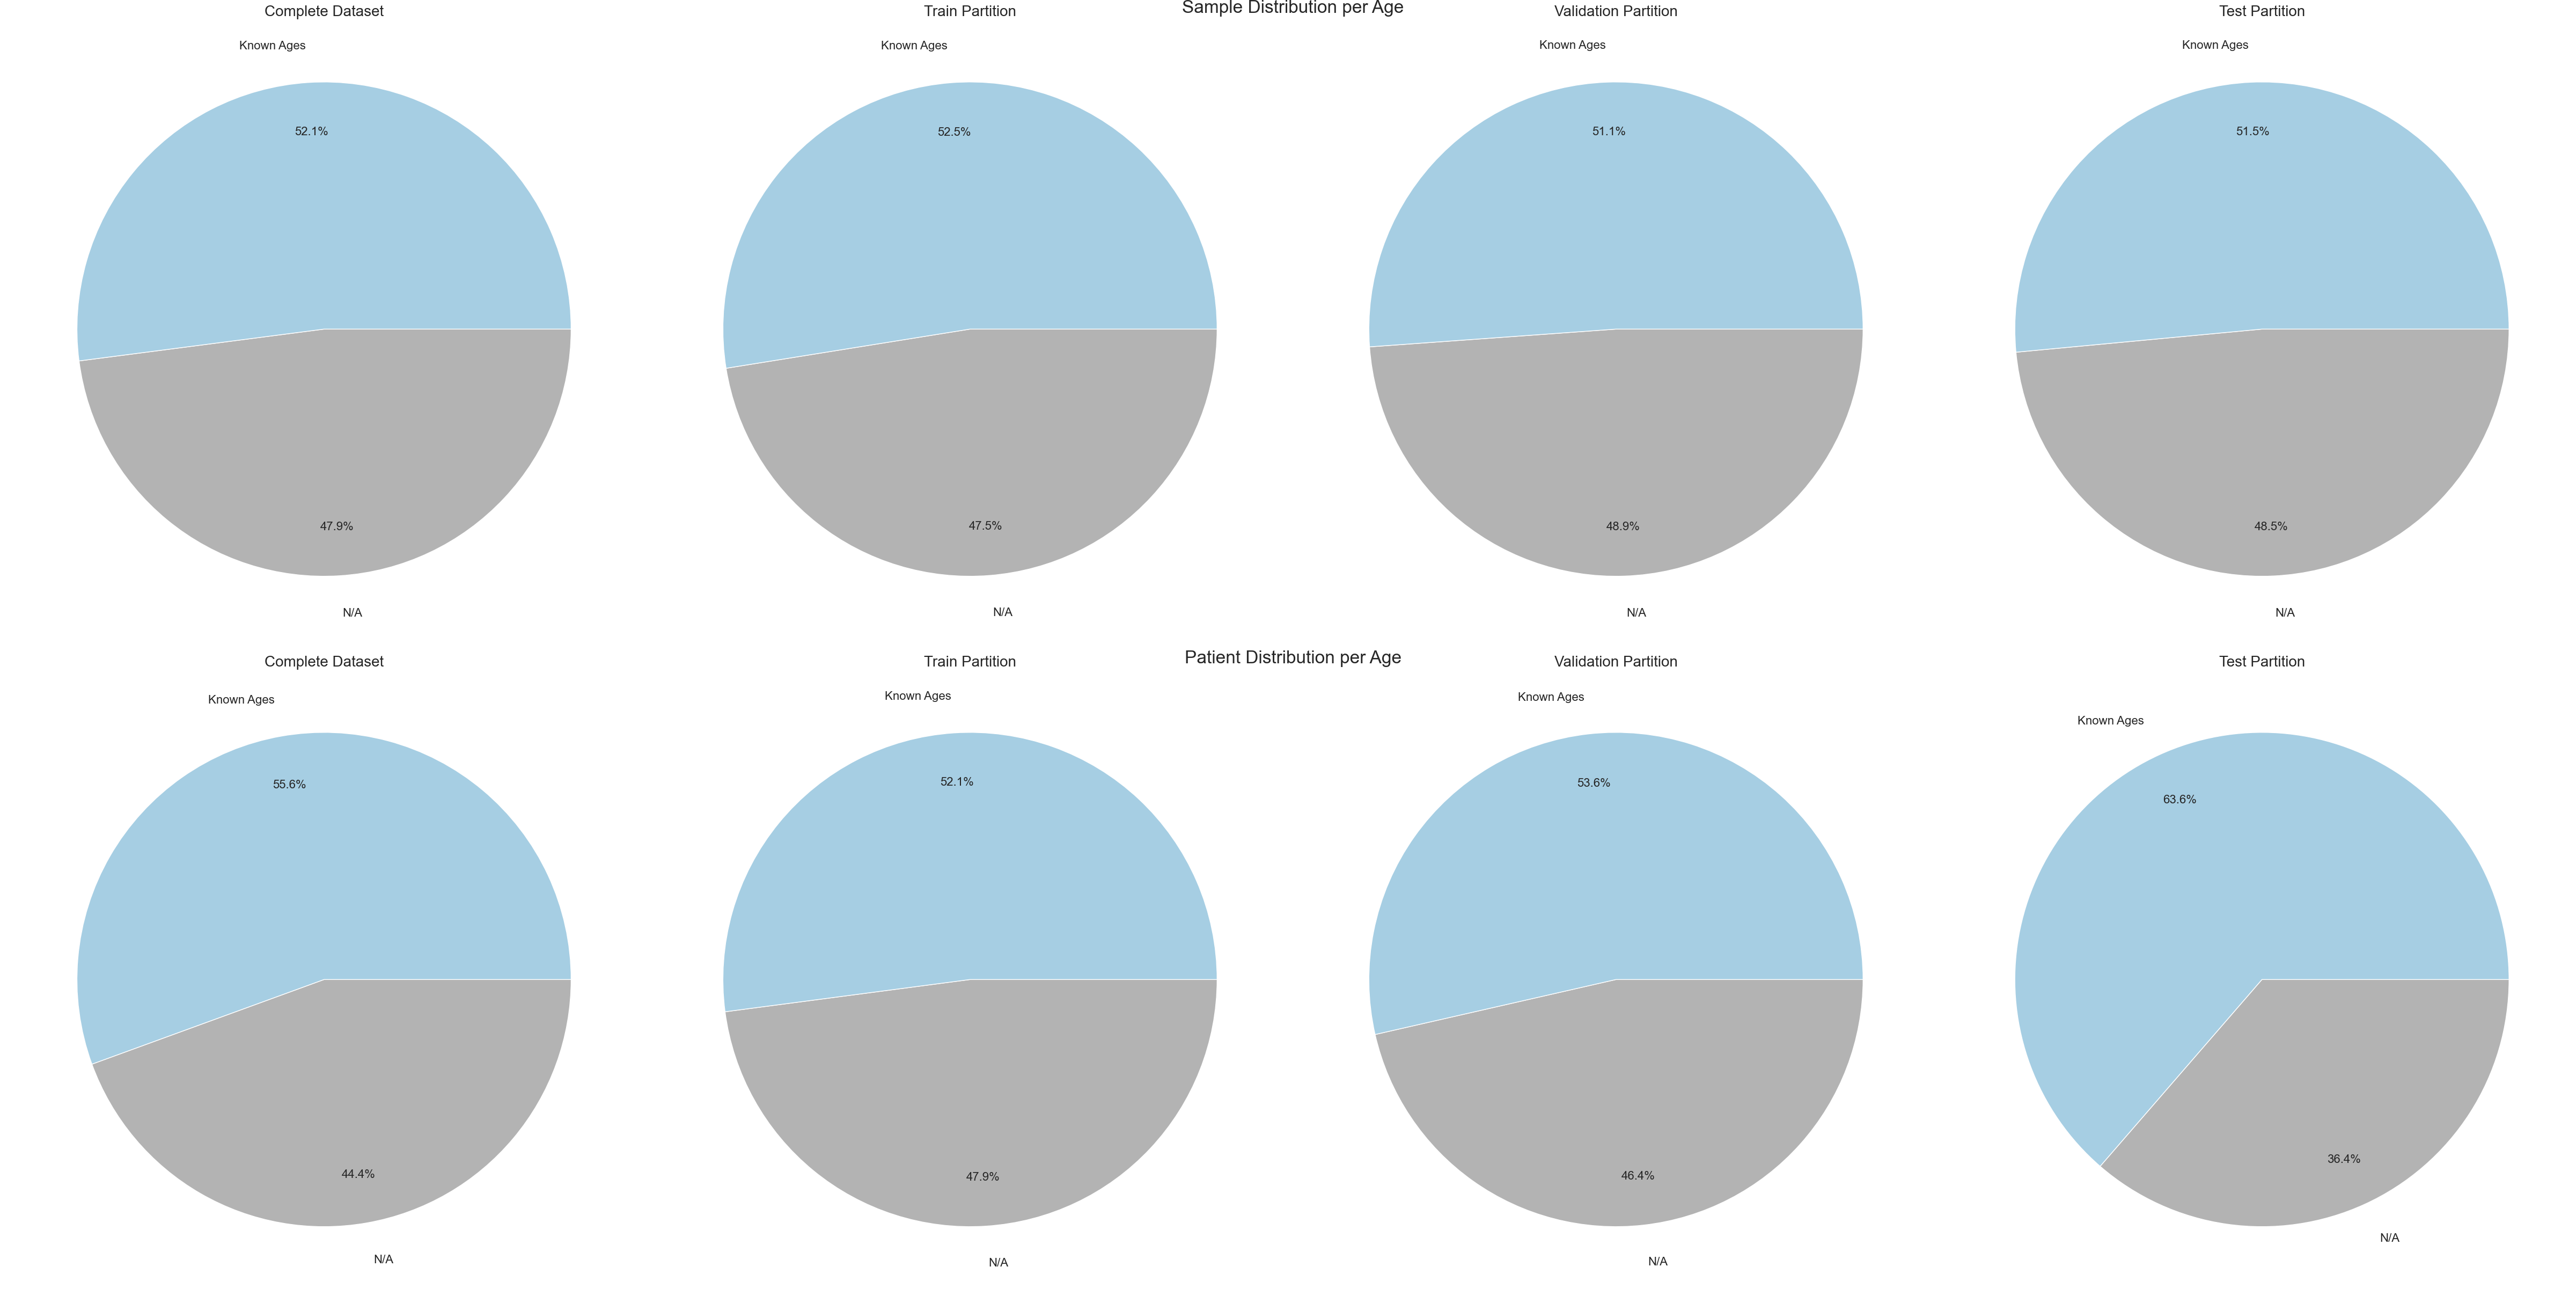

In [25]:
plot.column_as_pies( samples_df, patient_df, "age", dataset_name, figsize = (48, 24))

In [26]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = False )

Sample Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 42286 
 25404 
 8451 
 8431 
 
 
 Known Ages 
 45912 
 28116 
 8847 
 8949 
 
 
 SUM 
 88198 
 53520 
 17298 
 17380 
 
 
 Patient Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 567 
 322 
 117 
 128 
 
 
 Known Ages 
 709 
 350 
 135 
 224 
 
 
 SUM 
 1276 
 672 
 252 
 352

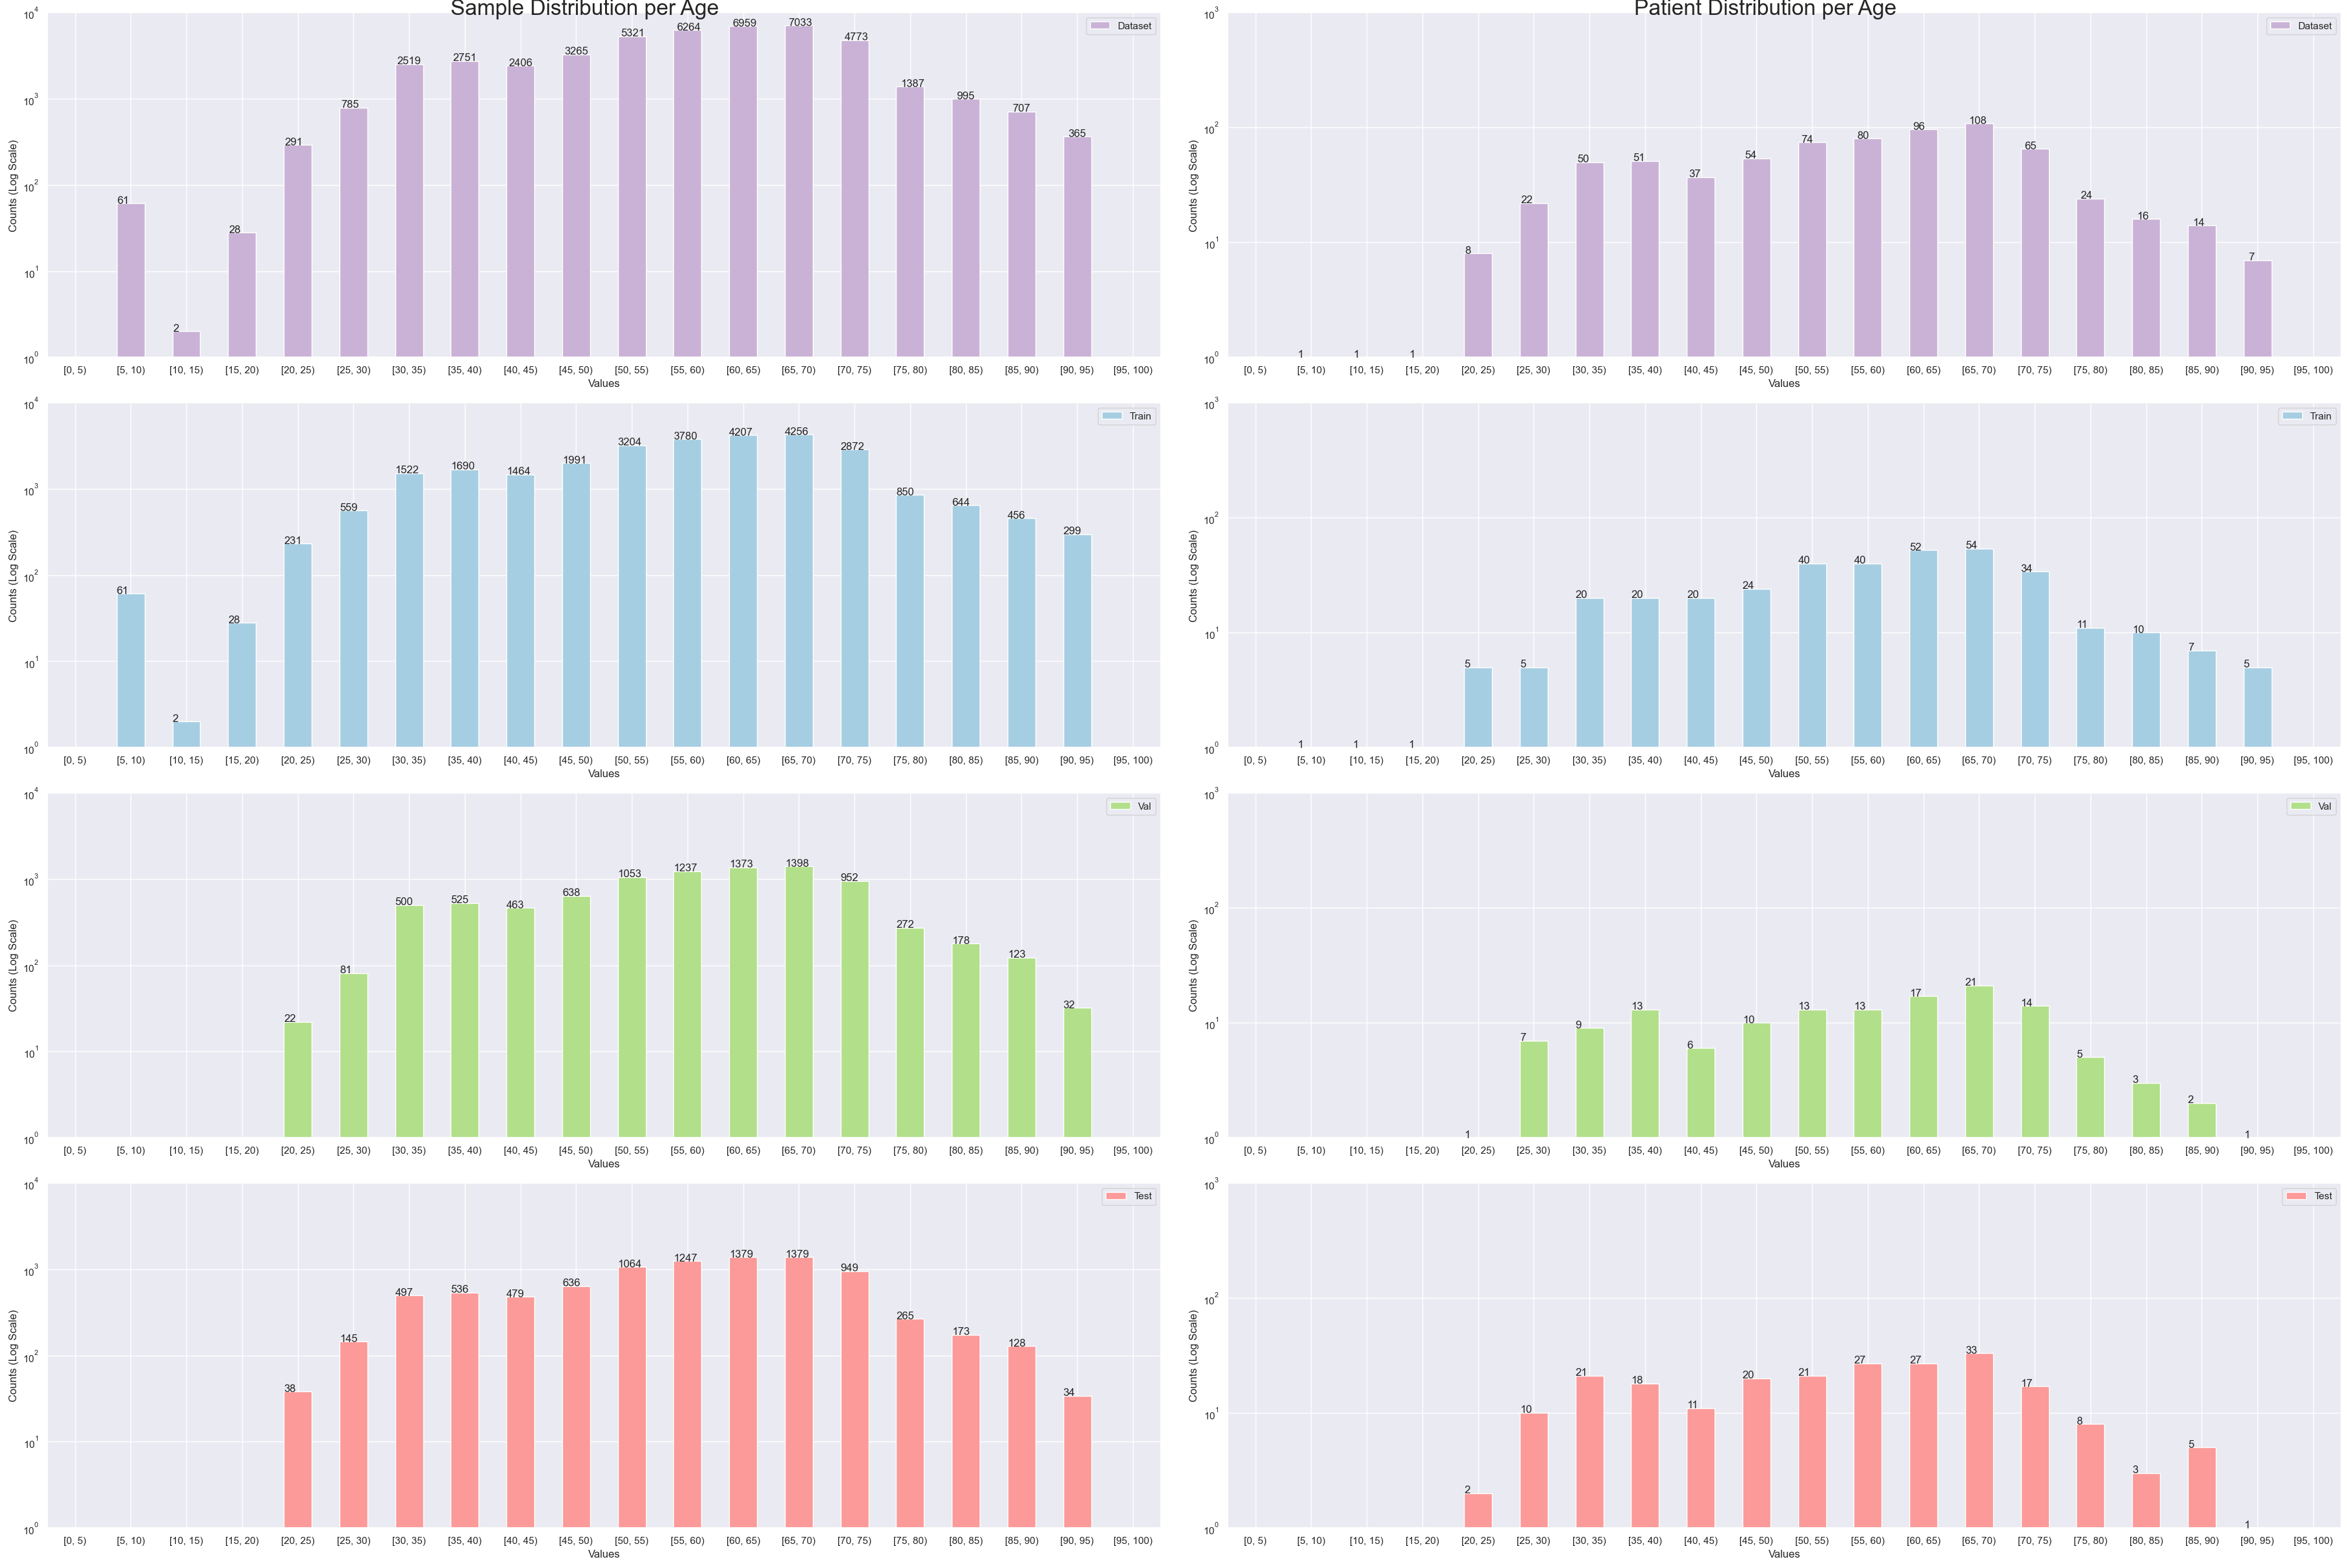

In [27]:
plot.column_as_histograms( samples_df, patient_df, "age", dataset_name, figsize = (36, 24))

In [28]:
plot.column_as_table( samples_df, patient_df, "age", dataset_name, bin_flag = True )

Sample Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 [0, 5) 
 0 
 0 
 0 
 0 
 
 
 [5, 10) 
 61 
 61 
 0 
 0 
 
 
 [10, 15) 
 2 
 2 
 0 
 0 
 
 
 [15, 20) 
 28 
 28 
 0 
 0 
 
 
 [20, 25) 
 291 
 231 
 22 
 38 
 
 
 [25, 30) 
 785 
 559 
 81 
 145 
 
 
 [30, 35) 
 2519 
 1522 
 500 
 497 
 
 
 [35, 40) 
 2751 
 1690 
 525 
 536 
 
 
 [40, 45) 
 2406 
 1464 
 463 
 479 
 
 
 [45, 50) 
 3265 
 1991 
 638 
 636 
 
 
 [50, 55) 
 5321 
 3204 
 1053 
 1064 
 
 
 [55, 60) 
 6264 
 3780 
 1237 
 1247 
 
 
 [60, 65) 
 6959 
 4207 
 1373 
 1379 
 
 
 [65, 70) 
 7033 
 4256 
 1398 
 1379 
 
 
 [70, 75) 
 4773 
 2872 
 952 
 949 
 
 
 [75, 80) 
 1387 
 850 
 272 
 265 
 
 
 [80, 85) 
 995 
 644 
 178 
 173 
 
 
 [85, 90) 
 707 
 456 
 123 
 128 
 
 
 [90, 95) 
 365 
 299 
 32 
 34 
 
 
 [95, 100) 
 0 
 0 
 0 
 0 
 
 
 SUM 
 45912 
 28116 
 8847 
 8949 
 
 
 Patient Distribution
 by Age 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 [0, 5) 
 0 
 0 
 0 
 0 
 
 
 [5, 10) 
 1 
 1 
 0 
 0 
 
 
 [10, 15) 
 1 
 1 
 0 
 0 
 
 
 [15, 20) 
 1 
 1 
 0 
 0 
 
 
 [20, 25) 
 8 
 5 
 1 
 2 
 
 
 [25, 30) 
 22 
 5 
 7 
 10 
 
 
 [30, 35) 
 50 
 20 
 9 
 21 
 
 
 [35, 40) 
 51 
 20 
 13 
 18 
 
 
 [40, 45) 
 37 
 20 
 6 
 11 
 
 
 [45, 50) 
 54 
 24 
 10 
 20 
 
 
 [50, 55) 
 74 
 40 
 13 
 21 
 
 
 [55, 60) 
 80 
 40 
 13 
 27 
 
 
 [60, 65) 
 96 
 52 
 17 
 27 
 
 
 [65, 70) 
 108 
 54 
 21 
 33 
 
 
 [70, 75) 
 65 
 34 
 14 
 17 
 
 
 [75, 80) 
 24 
 11 
 5 
 8 
 
 
 [80, 85) 
 16 
 10 
 3 
 3 
 
 
 [85, 90) 
 14 
 7 
 2 
 5 
 
 
 [90, 95) 
 7 
 5 
 1 
 1 
 
 
 [95, 100) 
 0 
 0 
 0 
 0 
 
 
 SUM 
 709 
 350 
 135 
 224

## Sex

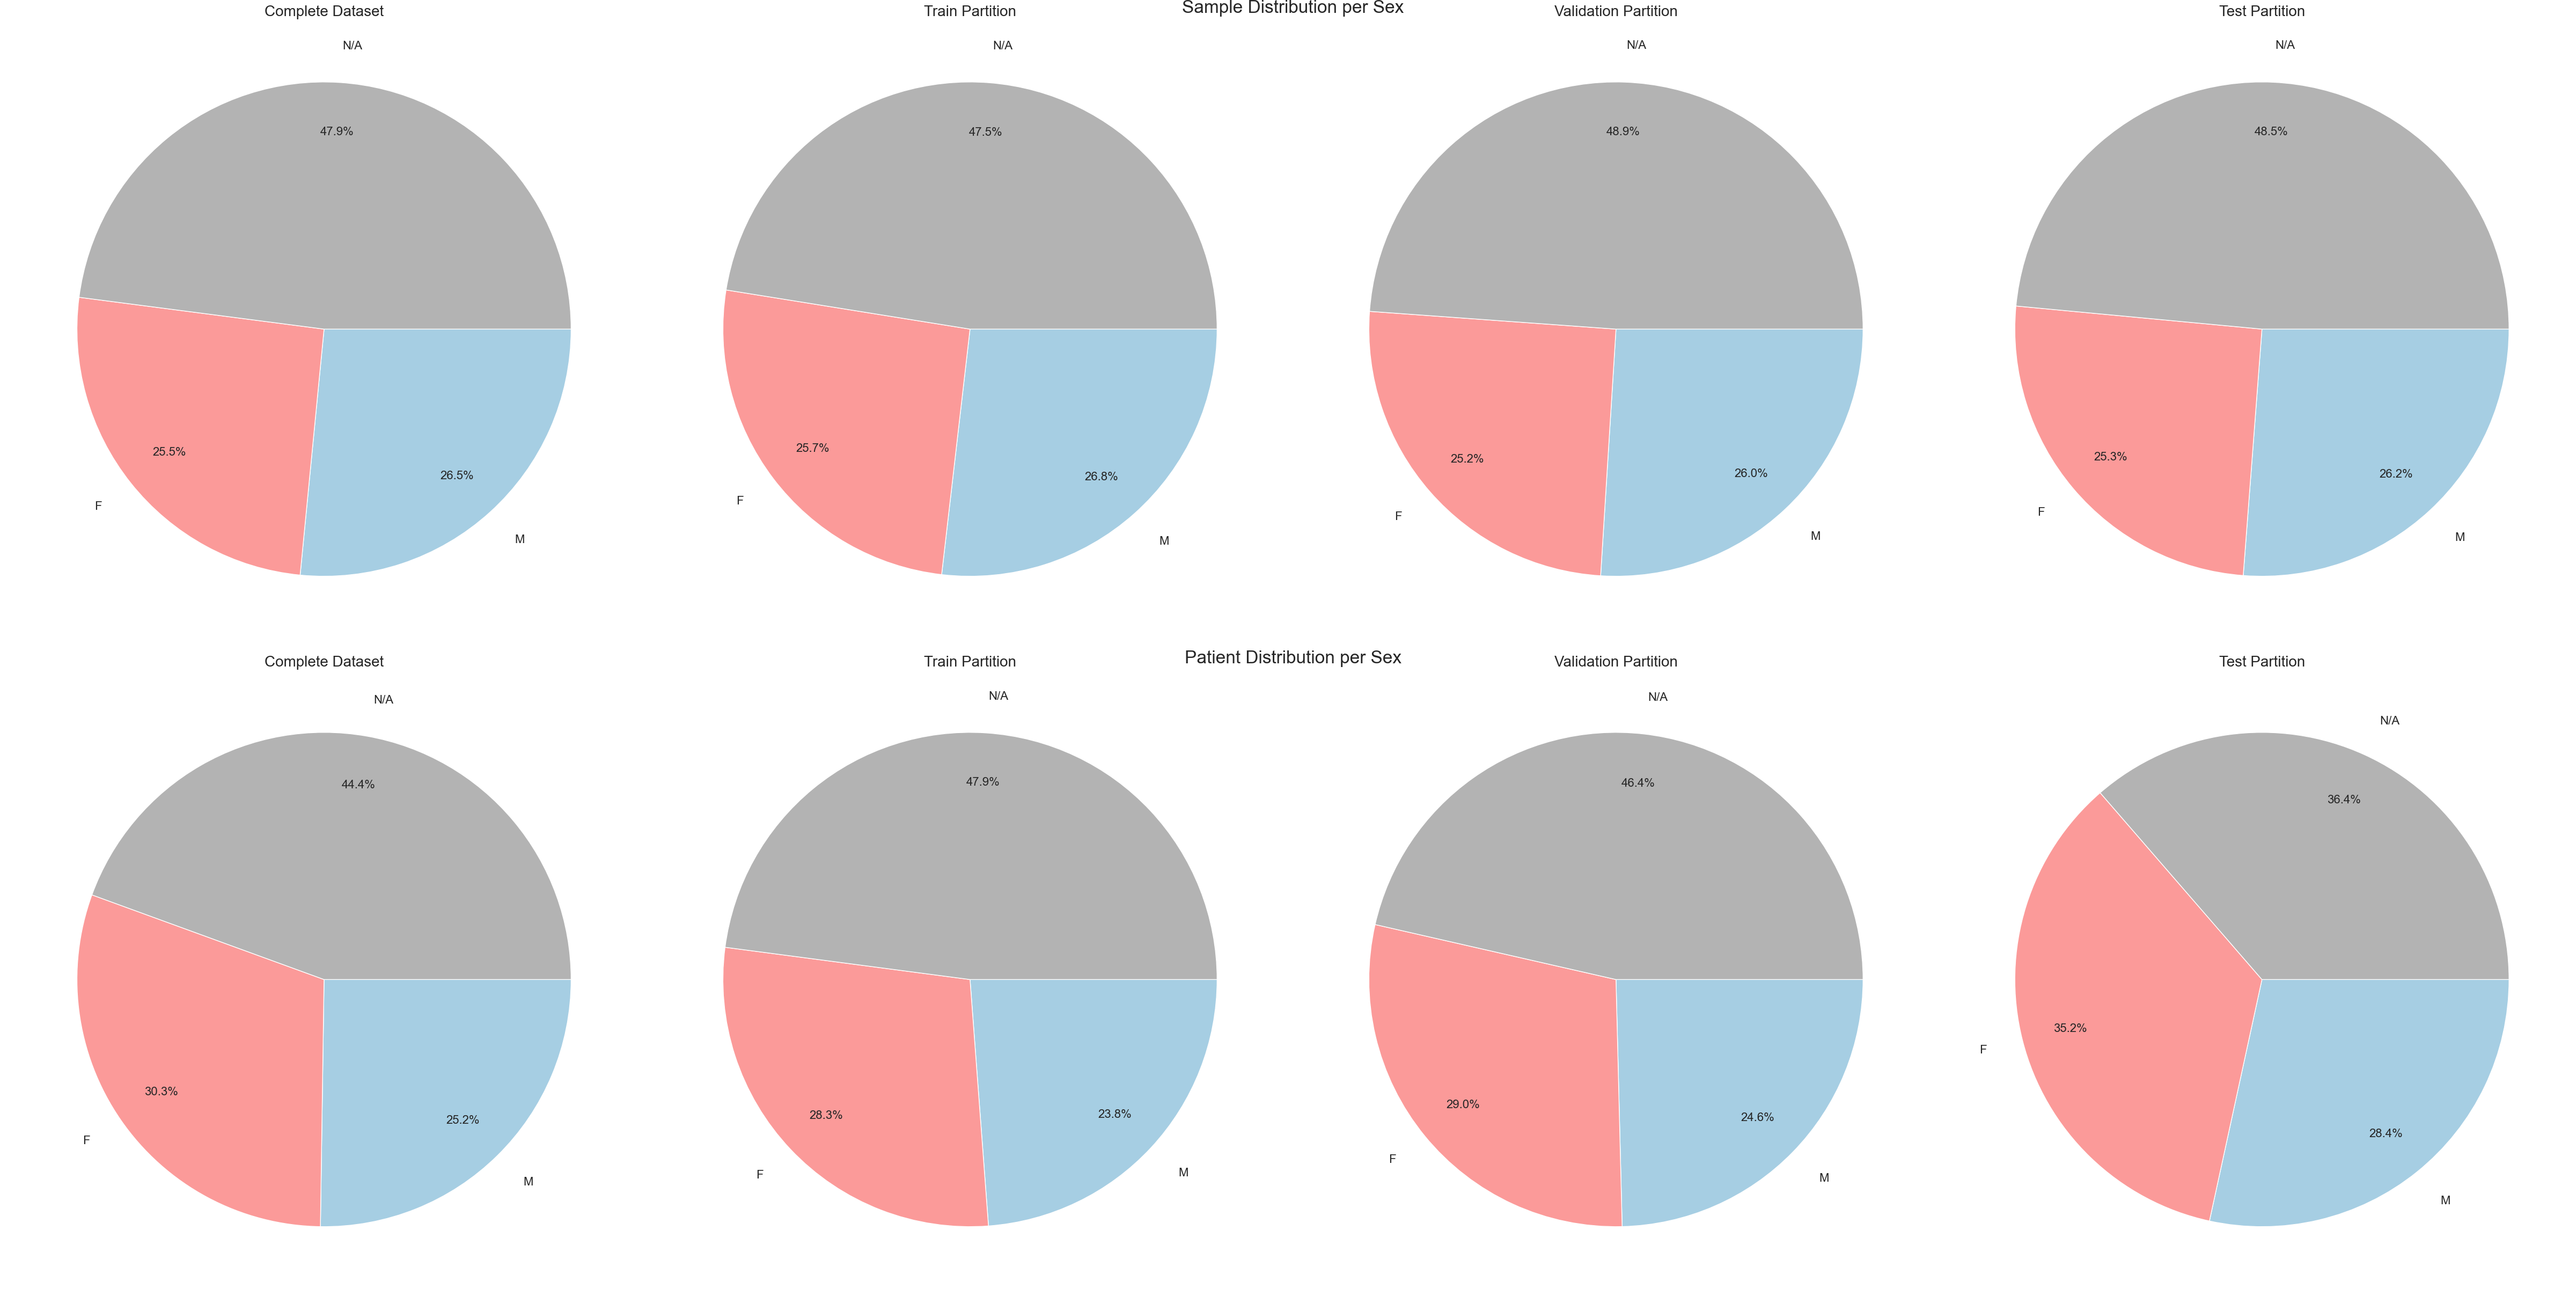

In [29]:
plot.column_as_pies( samples_df, patient_df, "sex", dataset_name, figsize = (48, 24) )

In [30]:
plot.column_as_table( samples_df, patient_df, "sex", dataset_name, bin_flag = False )

Sample Distribution
 by Sex 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 42286 
 25404 
 8451 
 8431 
 
 
 M 
 23412 
 14361 
 4496 
 4555 
 
 
 F 
 22500 
 13755 
 4351 
 4394 
 
 
 SUM 
 88198 
 53520 
 17298 
 17380 
 
 
 Patient Distribution
 by Sex 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 N/A 
 567 
 322 
 117 
 128 
 
 
 F 
 387 
 190 
 73 
 124 
 
 
 M 
 322 
 160 
 62 
 100 
 
 
 SUM 
 1276 
 672 
 252 
 352

## Country

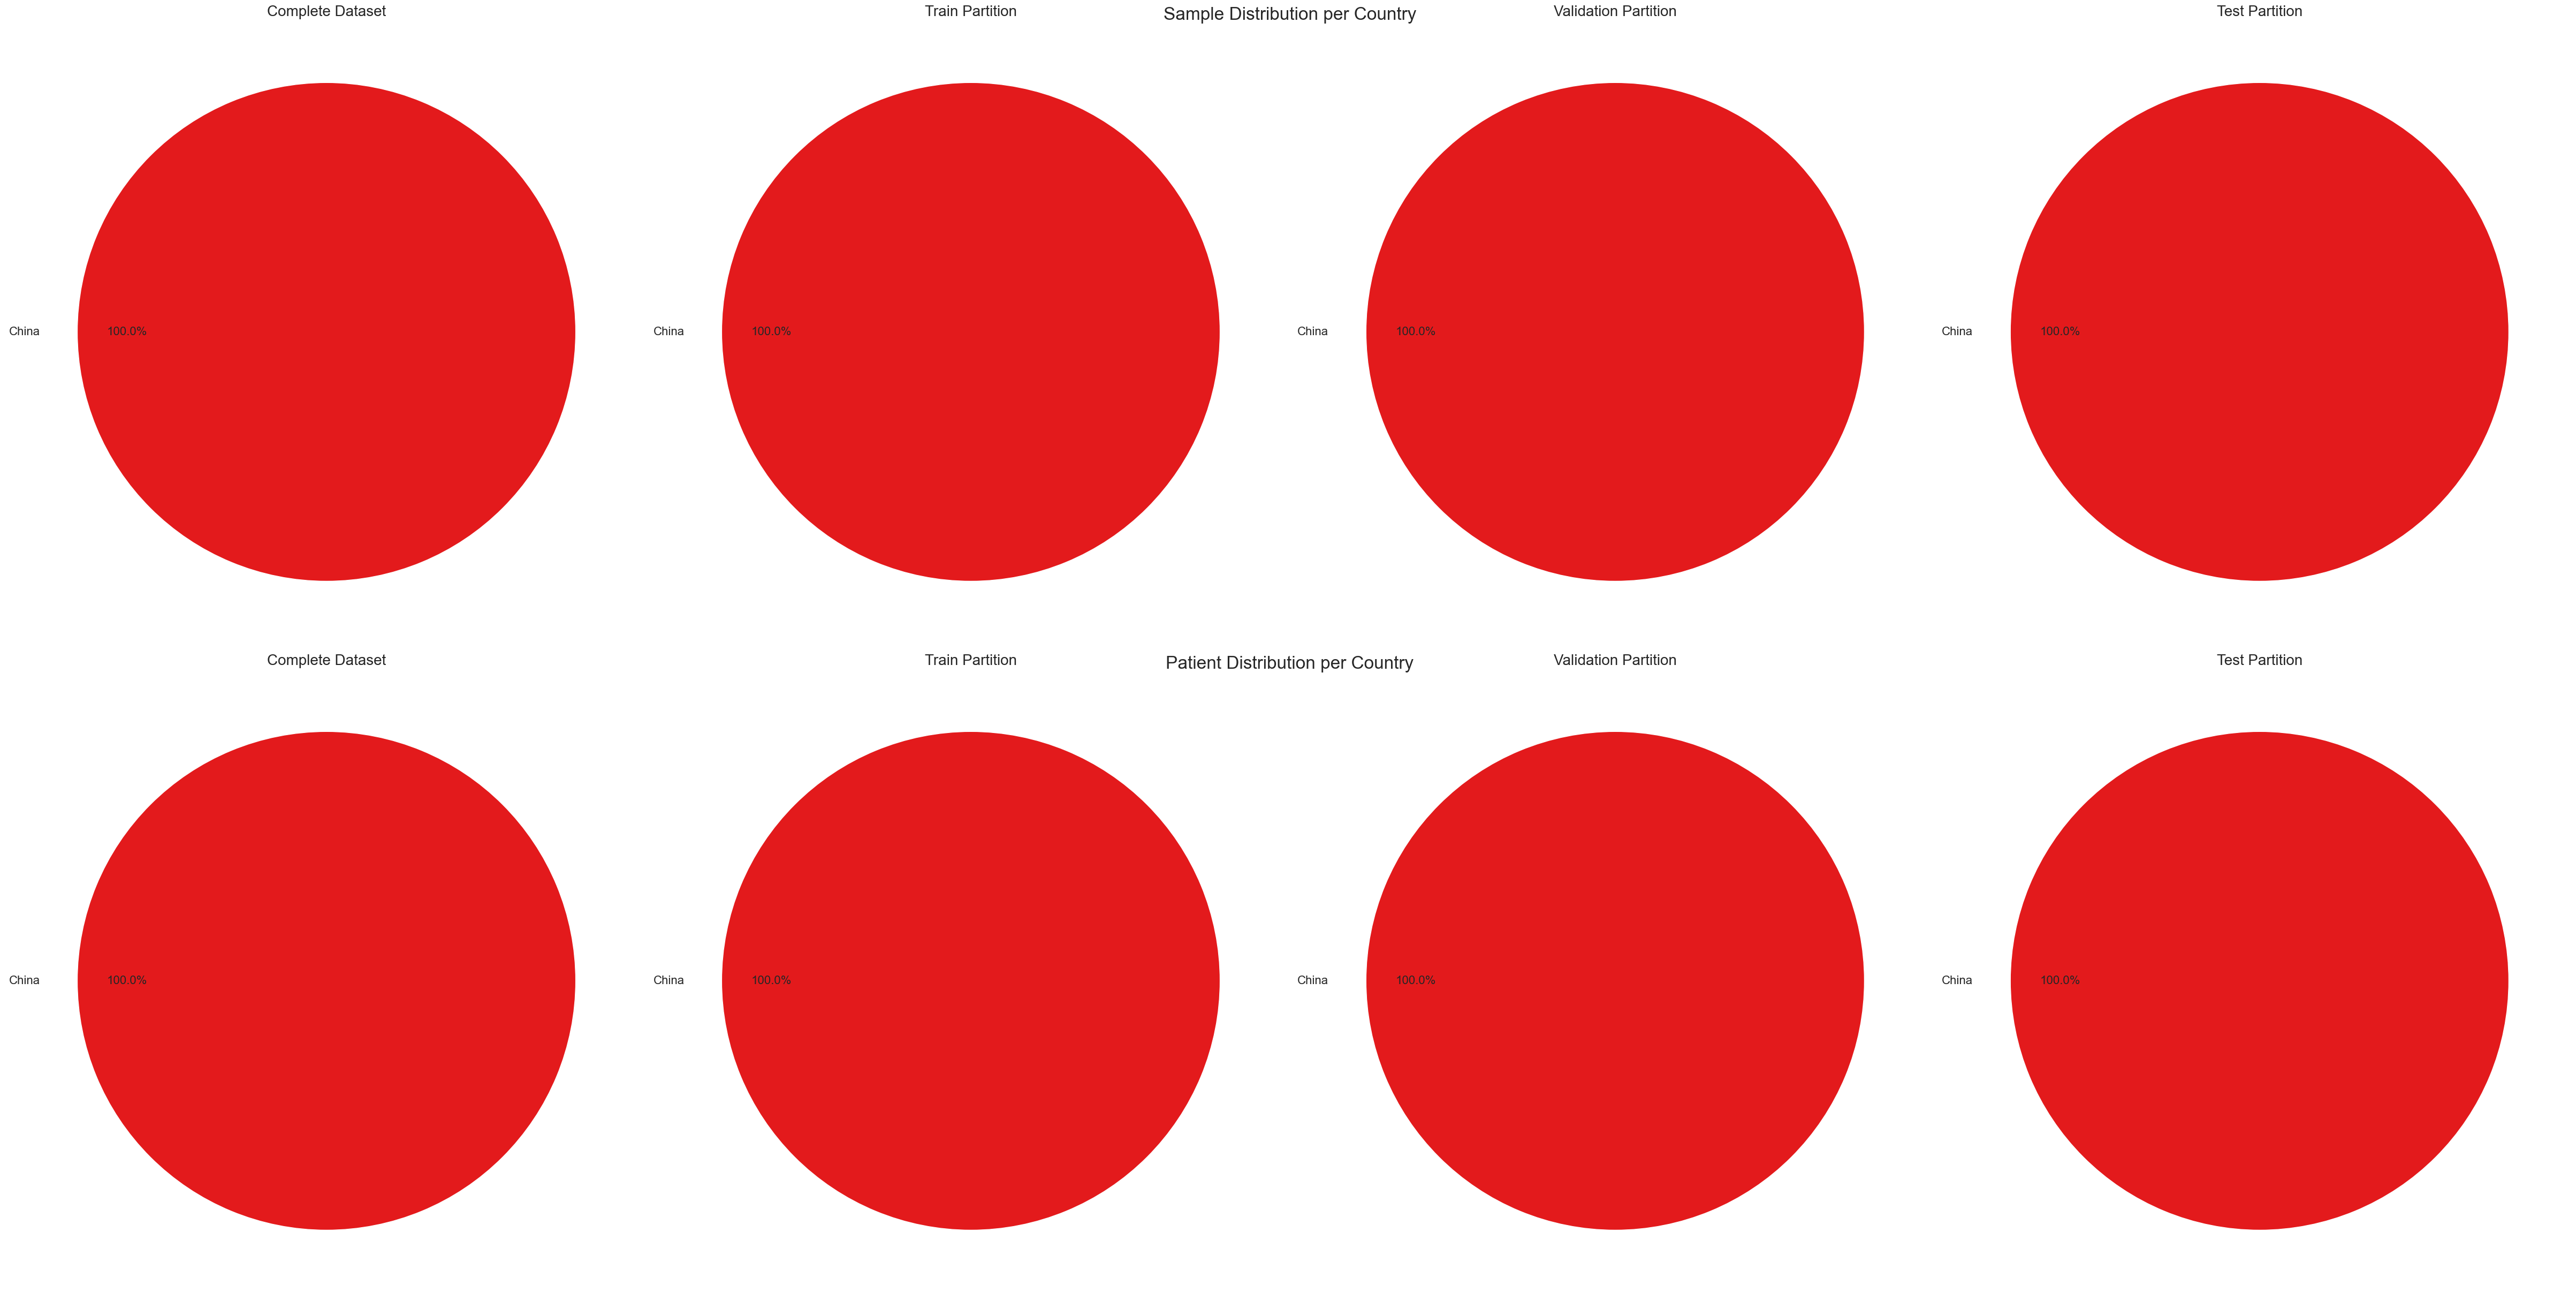

In [31]:
plot.column_as_pies( samples_df, patient_df, "country", dataset_name, figsize = (48, 24) )

In [32]:
plot.column_as_table( samples_df, patient_df, "country", dataset_name, bin_flag = False )

Sample Distribution
 by Country 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 China 
 88198 
 53520 
 17298 
 17380 
 
 
 SUM 
 88198 
 53520 
 17298 
 17380 
 
 
 Patient Distribution
 by Country 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 China 
 1276 
 672 
 252 
 352 
 
 
 SUM 
 1276 
 672 
 252 
 352

## Partition

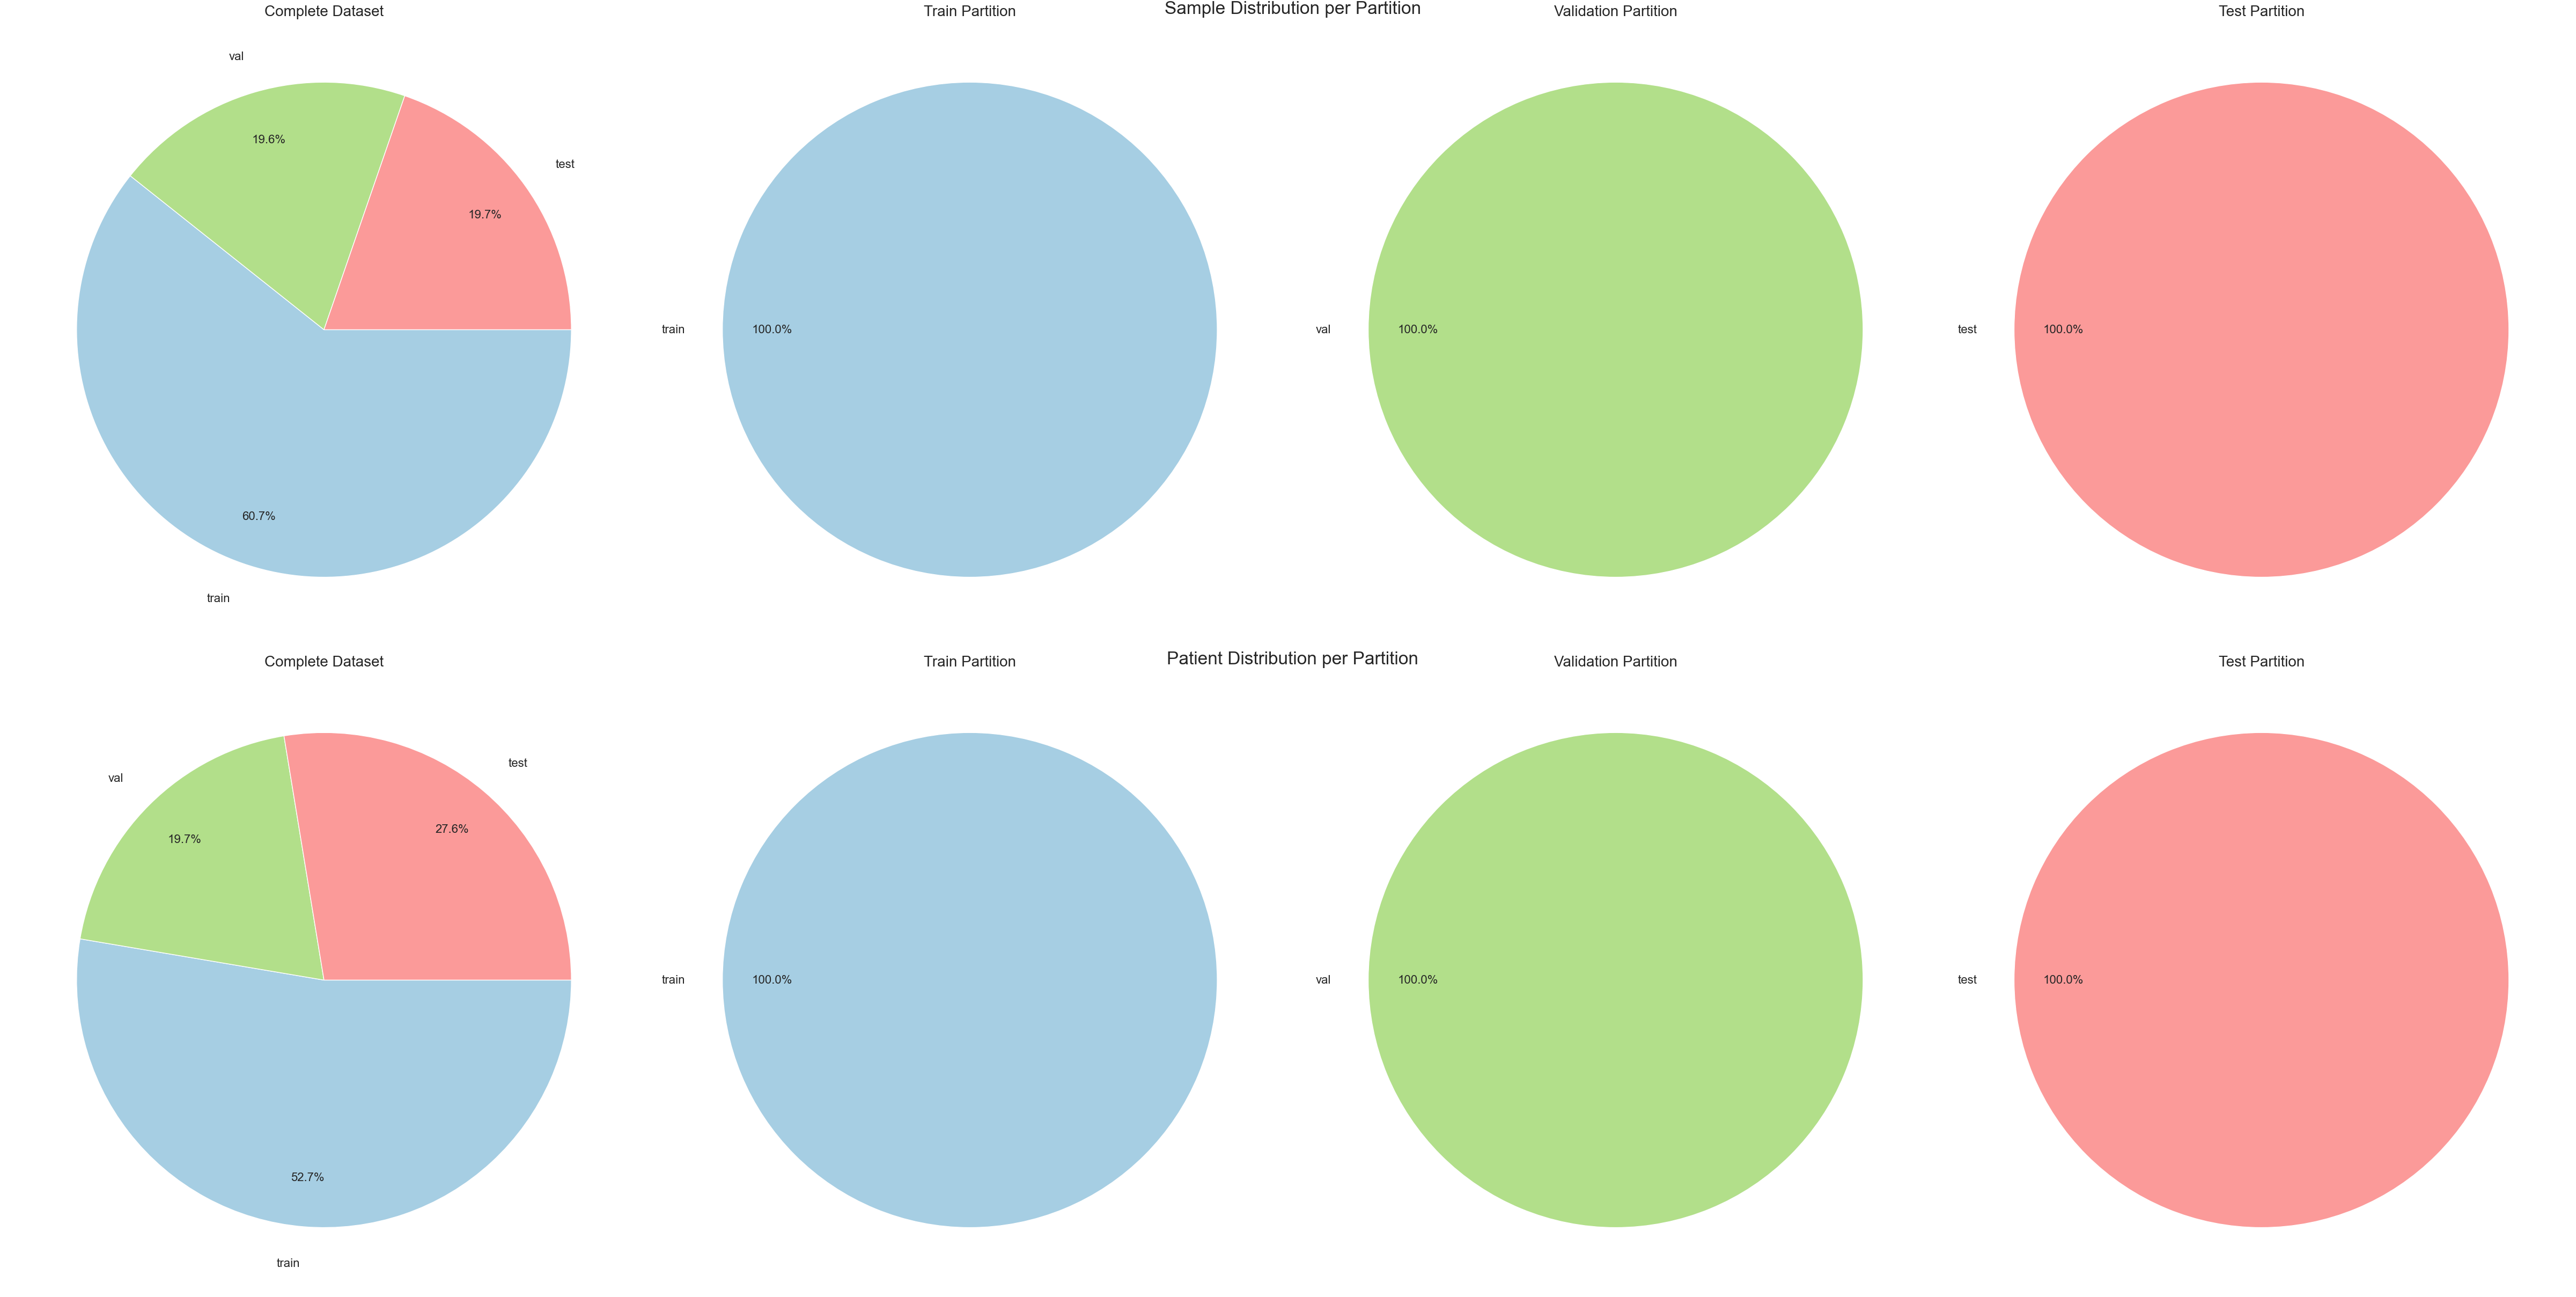

In [33]:
plot.column_as_pies( samples_df, patient_df, "partition", dataset_name, figsize = (48, 24) )

In [34]:
plot.column_as_table( samples_df, patient_df, "partition", dataset_name, bin_flag = False )

Sample Distribution
 by Partition 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 train 
 53520 
 53520 
 0 
 0 
 
 
 test 
 17380 
 0 
 0 
 17380 
 
 
 val 
 17298 
 0 
 17298 
 0 
 
 
 SUM 
 88198 
 53520 
 17298 
 17380 
 
 
 Patient Distribution
 by Partition 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 train 
 672 
 672 
 0 
 0 
 
 
 test 
 352 
 0 
 0 
 352 
 
 
 val 
 252 
 0 
 252 
 0 
 
 
 SUM 
 1276 
 672 
 252 
 352

## Slice Selection

In [35]:
plot.column_as_pies( samples_df, patient_df, "slice_selection", dataset_name, figsize = (48, 24) )

In [36]:
plot.column_as_table( samples_df, patient_df, "slice_selection", dataset_name, bin_flag = False )

Sample Distribution
 by Slice Selection 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 Expert 
 18352 
 11012 
 3670 
 3670 
 
 
 Automatic 
 46997 
 28767 
 9064 
 9166 
 
 
 N/A 
 22849 
 13741 
 4564 
 4544 
 
 
 SUM 
 88198 
 53520 
 17298 
 17380 
 
 
 Patient Distribution
 by Slice Selection 
 
 
 
 Dataset 
 Train 
 Val 
 Test 
 
 
 Values 
 
 
 
 
 
 
 
 
 Expert 
 373 
 216 
 78 
 79 
 
 
 Automatic 
 774 
 384 
 144 
 246 
 
 
 N/A 
 129 
 72 
 30 
 27 
 
 
 SUM 
 1276 
 672 
 252 
 352

# Registering Changes

In [37]:
# Dict that maps patient_ids to new sources
id2source_dict = { row["patient_id"]: row["source"] for idx, row in patient_df.iterrows() }

# Reads the CNCB and iCTCF csvs
CNCB_metadata_csv_path = os.path.join(metadata_dir, "CNCB_data.csv")
CNCB_metadata_df = pd.read_csv(CNCB_metadata_csv_path, sep = ";", na_filter = False, dtype={"age": str})
os.remove(CNCB_metadata_csv_path)

iCTCF_metadata_csv_path = os.path.join(metadata_dir, "iCTCF_data.csv")
iCTCF_metadata_df = pd.read_csv( iCTCF_metadata_csv_path, sep = ";", na_filter = False, dtype={"age": str})
os.remove(iCTCF_metadata_csv_path)

# Concatenates both dataframes and saves the result as CSV
combined_df = pd.concat([ CNCB_metadata_df, iCTCF_metadata_df ], ignore_index = True )
combined_df["source"] = combined_df.apply( lambda x: id2source_dict[x["patient_id"]], axis = 1 )

In [38]:
# Saves the Comp_CNCB_iCTCF_a dataframe as csv file
Comp_CNCB_iCTCF_a_metadata_df = combined_df[combined_df["source"] == "miniCNCB"]
Comp_CNCB_iCTCF_a_metadata_df.to_csv( os.path.join(metadata_dir, "miniCNCB_data.csv"), index = False, sep = ";" )
Comp_CNCB_iCTCF_a_metadata_df.head()

filename patient_id    source     class country sex   age  \
0  NCP_96_1328_0032.png     NCP_96  miniCNCB  COVID-19   China   M  74.0   
1  NCP_96_1328_0035.png     NCP_96  miniCNCB  COVID-19   China   M  74.0   
2  NCP_96_1328_0036.png     NCP_96  miniCNCB  COVID-19   China   M  74.0   
3  NCP_96_1328_0037.png     NCP_96  miniCNCB  COVID-19   China   M  74.0   
4  NCP_96_1328_0038.png     NCP_96  miniCNCB  COVID-19   China   M  74.0   

  partition slice_selection  x_min  y_min  x_max  y_max verified_finding  \
0     train          Expert      9     94    512    405              Yes   
1     train          Expert     10    106    512    405              Yes   
2     train          Expert     10    105    512    406              Yes   
3     train          Expert     11    104    512    406              Yes   
4     train          Expert     11    103    512    406              Yes   

    view modality  interpolation                             path  
0  Axial       CT              3  CNCB\train\NCP_96_1328_0032.png  
1  Axial       CT              4  CNCB\train\NCP_96_1328_0035.png  
2  Axial       CT              2  CNCB\train\NCP_96_1328_0036.png  
3  Axial       CT              4  CNCB\train\NCP_96_1328_0037.png  
4  Axial       CT              4  CNCB\train\NCP_96_1328_0038.png

In [39]:
# Saves the Comp_CNCB_iCTCF_b dataframe as csv file
Comp_CNCB_iCTCF_b_metadata_df = combined_df[combined_df["source"] == "Comp_CNCB_iCTCF"]
Comp_CNCB_iCTCF_b_metadata_df.to_csv( os.path.join(metadata_dir, "Comp_CNCB_iCTCF_data.csv"), index = False, sep = ";" )
Comp_CNCB_iCTCF_b_metadata_df.head()

filename patient_id           source      class country  \
12521  CP_1137_3355_0090.png    CP_1137  Comp_CNCB_iCTCF  Pneumonia   China   
12522  CP_1137_3355_0091.png    CP_1137  Comp_CNCB_iCTCF  Pneumonia   China   
12523  CP_1137_3355_0092.png    CP_1137  Comp_CNCB_iCTCF  Pneumonia   China   
12524  CP_1137_3355_0093.png    CP_1137  Comp_CNCB_iCTCF  Pneumonia   China   
12525  CP_1137_3355_0094.png    CP_1137  Comp_CNCB_iCTCF  Pneumonia   China   

       sex  age partition slice_selection  x_min  y_min  x_max  y_max  \
12521  N/A  N/A     train          Expert     34     93    483    398   
12522  N/A  N/A     train          Expert     35     92    483    398   
12523  N/A  N/A     train          Expert     36     92    482    398   
12524  N/A  N/A     train          Expert     36     91    482    398   
12525  N/A  N/A     train          Expert     37     91    482    398   

      verified_finding   view modality  interpolation  \
12521              Yes  Axial       CT              2   
12522              Yes  Axial       CT              1   
12523              Yes  Axial       CT              2   
12524              Yes  Axial       CT              2   
12525              Yes  Axial       CT              1   

                                   path  
12521  CNCB\train\CP_1137_3355_0090.png  
12522  CNCB\train\CP_1137_3355_0091.png  
12523  CNCB\train\CP_1137_3355_0092.png  
12524  CNCB\train\CP_1137_3355_0093.png  
12525  CNCB\train\CP_1137_3355_0094.png